In [1]:
# ----------------------------------------------------------------------------------------
# Constants and Configurations
INPUT_FOLDER = 'Stage1'                        # Source data folder
PREPROCESSED_DATA_FOLDER = 'preprocessed/'      # Preprocessed data folder
STAGE1_LABELS = 'stage1_labels.csv'            # Labels CSV file
BATCH_SIZE = 32                                 # Number of subjects per batch
EXAMPLES_PER_SUBJECT = 182                      # Examples per subject
IMAGE_DIM = 250                                 # Height and width of the images
LEARNING_RATE = 0.002                            # Learning rate for the network
NUM_EPOCHS = 1                                  # Number of training epochs
TRAIN_TEST_SPLIT_RATIO = 0.2                    # Train-test split ratio

# Paths for logs and models
TRAIN_PATH = 'tsa_logs/train/'                  # Path for training logs
MODEL_PATH = 'tsa_logs/model/'                  # Path for model files
MODEL_NAME_TEMPLATE = 'tsa-alexnet-lr-{lr}-dim-{dim}-tz-{tz}.pth'

# ----------------------------------------------------------------------------------------

import os
import re
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import tsahelper.tsahelper as tsa

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import alexnet

import matplotlib.pyplot as plt
import seaborn as sns

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
def numpy_threshold(image, low=None, high=None, newval=0):
    """
    NumPy-based thresholding function
    """
    output = image.copy()
    if low is not None:
        output[output < low] = newval
    if high is not None:
        output[output > high] = newval
    return output

def new_spread_spectrum(img):
    """
    Modified spread_spectrum function using numpy_threshold instead of scipy.stats.threshold
    """
    # Apply threshold
    img = numpy_threshold(img, low=12, newval=0)
    
    # Normalize to 0-1 range
    if img.max() > 0:
        img = img / img.max()
    
    return img

# Replace the original spread_spectrum function
tsa.spread_spectrum = new_spread_spectrum

In [3]:
def _save_batches_zonewise(threat_zone_examples, preprocessed_folder, batch_num, tz_num):
    """
    Helper function to save preprocessed batches for a specific threat zone.
    
    Parameters:
    -----------
    threat_zone_examples : list
        List of examples for the threat zone.
    preprocessed_folder : str
        Directory to save preprocessed data.
    batch_num : int
        Current batch number.
    tz_num : int
        Threat zone number.
    """
    try:
        if not threat_zone_examples:
            print(f"No examples for threat zone {tz_num}")
            return

        # Convert examples to numpy arrays
        features = np.array([ex[1] for ex in threat_zone_examples], dtype=np.float32)
        labels = np.array([ex[2] for ex in threat_zone_examples], dtype=np.int64)

        # Create a dictionary to save both features and labels
        save_dict = {
            'features': features,
            'labels': labels
        }

        # Construct filename
        filename = os.path.join(
            preprocessed_folder, 
            f'preprocessed_TSA_scans-tz{tz_num+1}-{features.shape[1]}-{features.shape[2]}-b{batch_num}.npz'
        )

        # Save batch using np.savez_compressed for better space efficiency
        np.savez_compressed(filename, **save_dict)
        print(f"Saved batch: {filename} | Features shape: {features.shape}, Labels shape: {labels.shape}")

    except Exception as e:
        print(f"Error saving batch for threat zone {tz_num}: {e}")
        import traceback
        traceback.print_exc()


In [4]:
def preprocess_tsa_data(
    INPUT_FOLDER=INPUT_FOLDER,
    STAGE1_LABELS=STAGE1_LABELS,
    PREPROCESSED_DATA_FOLDER=PREPROCESSED_DATA_FOLDER,
    BATCH_SIZE=BATCH_SIZE,
    EXAMPLES_PER_SUBJECT=EXAMPLES_PER_SUBJECT
):
    """
    Preprocesses TSA dataset by reading images, applying transformations, 
    and saving preprocessed data zone-wise to manage memory efficiently.
    """
    
    # Ensure output directory exists
    os.makedirs(PREPROCESSED_DATA_FOLDER, exist_ok=True)
    
    # Read labels file
    try:
        df = pd.read_csv(STAGE1_LABELS)
        
        # Extract Subject and Zone from the Id column
        df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
        
        # Convert Zone to numeric, removing 'Zone' prefix
        df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
    except Exception as e:
        print(f"Error reading labels file: {e}")
        raise

    # Get list of all unique zones
    unique_zones = df['Zone'].unique()
    print(f"Unique zones found: {unique_zones}")

    # Get list of all subjects
    SUBJECT_LIST = df['Subject'].unique()
    print(f"Total subjects to process: {len(SUBJECT_LIST)}")
    
    # Initialize tracking and saving items
    batch_num = 1
    start_time = timer()
    
    for tz_num in unique_zones:
        threat_zone_examples = []  # Reset for each zone
        print(f"\nProcessing Threat Zone {tz_num +1}")
        
        for subject in SUBJECT_LIST:
            try:
                print(f't+> {timer()-start_time:.3f} | Subject #: {subject}')
                
                # Read in the images
                images = tsa.read_data(os.path.join(INPUT_FOLDER, f'{subject}.aps'))
                images = images.transpose()  # Shape: (16, 620, 512)

                # Get labels for the current threat zone
                label_row = df[(df['Subject'] == subject) & (df['Zone'] == tz_num)]
                label = 1 if not label_row.empty and label_row['Probability'].values[0] == 1 else 0
                print(f"Subject {subject} | Threat Zone {tz_num +1} Label: {label}")

                for img_num, img in enumerate(images):
                    if tsa.zone_slice_list[tz_num][img_num] is not None:
                        try:
                            # Image processing steps
                            base_img = np.flipud(img)
                            rescaled_img = tsa.convert_to_grayscale(base_img)
                            high_contrast_img = tsa.spread_spectrum(rescaled_img)
                            masked_img = tsa.roi(high_contrast_img, tsa.zone_slice_list[tz_num][img_num])
                            cropped_img = tsa.crop(masked_img, tsa.zone_crop_list[tz_num][img_num])
                            normalized_img = tsa.normalize(cropped_img)
                            zero_centered_img = tsa.zero_center(normalized_img)

                            # Append processed example
                            threat_zone_examples.append([[tz_num], zero_centered_img, label])
                            
                            print(f'Processed Threat Zone: {tz_num+1} | Image: {img_num+1}, Label: {label}')
                        except Exception as e:
                            print(f"Error processing image {img_num} in zone {tz_num+1}: {e}")
                            import traceback
                            traceback.print_exc()

                    # Batch saving logic
                    if len(threat_zone_examples) >= BATCH_SIZE * EXAMPLES_PER_SUBJECT:
                        _save_batches_zonewise(threat_zone_examples, PREPROCESSED_DATA_FOLDER, batch_num, tz_num)
                        threat_zone_examples = []
                        batch_num += 1

            except Exception as e:
                print(f"Error processing subject {subject}: {e}")
                import traceback
                traceback.print_exc()
                continue

        # Save any remaining examples for the current zone
        if threat_zone_examples:
            _save_batches_zonewise(threat_zone_examples, PREPROCESSED_DATA_FOLDER, batch_num, tz_num)
            threat_zone_examples = []
            batch_num += 1

    print("\nPreprocessing complete!")


In [5]:
import re  # Ensure re is imported

def get_train_test_file_list(preprocessed_folder, threat_zone, train_test_split_ratio=TRAIN_TEST_SPLIT_RATIO):
    """
    Splits preprocessed files into training and testing sets for a specific threat zone.
    
    Parameters:
    -----------
    preprocessed_folder : str
        Directory containing preprocessed .npz files.
    threat_zone : int
        Threat zone number (0-based indexing).
    train_test_split_ratio : float
        Ratio of data to be used for testing.
    
    Returns:
    --------
    tuple: (train_files, test_files)
    """
    FILE_LIST = [f for f in os.listdir(preprocessed_folder) 
                 if re.search(f'-tz{threat_zone +1}-', f)]
    
    np.random.shuffle(FILE_LIST)  # Shuffle to ensure randomness
    
    split_index = len(FILE_LIST) - max(int(len(FILE_LIST) * train_test_split_ratio), 1)
    TRAIN_SET_FILE_LIST = FILE_LIST[:split_index]
    TEST_SET_FILE_LIST = FILE_LIST[split_index:]
    
    print(f'Train/Test Split for Zone {threat_zone +1}: {len(TRAIN_SET_FILE_LIST)} train files, {len(TEST_SET_FILE_LIST)} test files')
    
    return TRAIN_SET_FILE_LIST, TEST_SET_FILE_LIST


In [6]:
class TZScanDataset(Dataset):
    def __init__(self, file_list, data_folder, transform=None):
        """
        Custom Dataset for TZ Scans with dynamic augmentation.
        
        Args:
            file_list (list): List of .npz filenames.
            data_folder (str): Path to the data folder.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.file_list = file_list
        self.data_folder = data_folder
        self.transform = transform
        self.indices = []
        self.file_offsets = {}
        self._create_index()

    def _create_index(self):
        """
        Creates an index mapping each sample to its corresponding file and offset.
        This avoids loading all data into memory.
        """
        current_index = 0
        for file in self.file_list:
            file_path = os.path.join(self.data_folder, file)
            try:
                data = np.load(file_path, allow_pickle=True)
                features = data['features']
                num_samples = features.shape[0]
                self.file_offsets[file] = (current_index, num_samples)
                self.indices.extend([(file, i) for i in range(num_samples)])
                current_index += num_samples
            except Exception as e:
                print(f"Error indexing file {file}: {e}")

    def __len__(self):
        return len(self.indices)
    """
    def __getitem__(self, idx):
        file, sample_idx = self.indices[idx]
        file_path = os.path.join(self.data_folder, file)
        try:
            data = np.load(file_path, allow_pickle=True)
            feature = data['features'][sample_idx]
            label = data['labels'][sample_idx]
            
            # Expand dimensions and replicate channels if necessary
            if len(feature.shape) == 2:
                feature = feature.reshape(1, feature.shape[0], feature.shape[1])
                feature = np.repeat(feature, 3, axis=0)  # Repeat to simulate 3 channels

            if self.transform:
                feature = self.transform(feature)
            else:
                feature = torch.tensor(feature, dtype=torch.float32)
            
            label = torch.tensor(label, dtype=torch.long)
            
            return feature, label

        except Exception as e:
            print(f"Error loading sample {sample_idx} from file {file}: {e}")
            return None, None
    """
    def __getitem__(self, idx):
        file, sample_idx = self.indices[idx]
        file_path = os.path.join(self.data_folder, file)
        try:
            data = np.load(file_path, allow_pickle=True)
            feature = data['features'][sample_idx]
            label = data['labels'][sample_idx]

            # Normalize the feature data (if it's in 16-bit range)
            feature = feature / 65535.0  # Normalize to [0, 1] if data is in 16-bit range

            # Ensure feature shape is correct for processing
            # If feature is of shape (16, 660, 512), we need to handle it properly
            if feature.shape[0] == 16:  # If it's the angular slice dimension
                # Select the first 3 angular slices (or apply a method to reduce it to 3 channels)
                feature = feature[:3]  # Take only the first 3 angular slices

            # Expand dimensions and replicate channels if necessary
            if len(feature.shape) == 2:
                feature = feature.reshape(1, feature.shape[0], feature.shape[1])
                feature = np.repeat(feature, 3, axis=0)  # Repeat to simulate 3 channels

            # Convert to tensor
            feature = torch.tensor(feature, dtype=torch.float32)
            label = torch.tensor(label, dtype=torch.long)

            # Apply transformations if provided
            if self.transform:
                feature = self.transform(feature)

            return feature, label

        except Exception as e:
            print(f"Error loading sample {sample_idx} from file {file}: {e}")
            return None, None



In [7]:
# Define on-the-fly augmentations
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


In [8]:
def load_data(file_list, data_folder, transform=None, batch_size=BATCH_SIZE, shuffle=True, num_workers=4):
    """
    Create DataLoader for given file list.
    
    Args:
        file_list (list): List of .npz filenames.
        data_folder (str): Path to data folder.
        transform (callable, optional): Transformations to apply.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the data.
        num_workers (int): Number of subprocesses to use for data loading.
    
    Returns:
        DataLoader: PyTorch DataLoader.
    """
    dataset = TZScanDataset(file_list, data_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)
    return dataloader


In [9]:
"""
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):

    Train the model with progress tracking.
    
    Args:
        model (nn.Module): Neural network model.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim): Optimization algorithm.
        num_epochs (int): Number of training epochs.
    
    Returns:
        dict: Training history for plotting.
        nn.Module: Trained model.
    model.to(DEVICE)
    
    # Tracking metrics
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'lr': []
    }
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3, 
        verbose=True
    )
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if inputs is None:
                continue  # Skip faulty batches
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Compute training metrics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
            
            # Progress print
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                if inputs is None:
                    continue  # Skip faulty batches
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        # Compute epoch metrics
        train_loss /= len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        val_loss /= len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        
        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['lr'].append(current_lr)
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | LR: {current_lr}')
    
    return history, model
    """
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, min_delta):
    """
    Train the model with batch-wise tracking for single epoch.

    Args:
        model (nn.Module): Neural network model.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        patience (int): Early stopping patience.
        min_delta (float): Minimum change in loss to qualify as improvement.
    
    Returns:
        dict: Training history.
        nn.Module: Trained model.
    """
    model.to(DEVICE)
    
    # Batch-wise tracking metrics
    history = {
        'batch_train_loss': [],
        'batch_train_accuracy': [],
        'batch_val_loss': [],
        'batch_val_accuracy': []
    }
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if inputs is None:
            continue  # Skip faulty batches
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute batch metrics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()

        # Store batch metrics
        history['batch_train_loss'].append(loss.item())
        history['batch_train_accuracy'].append(100. * train_correct / train_total)

        # Progress print
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
        
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            if inputs is None:
                continue  # Skip faulty batches
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

            # Store validation batch metrics
            history['batch_val_loss'].append(loss.item())
            history['batch_val_accuracy'].append(100. * val_correct / val_total)
    
    
    return history, model


In [10]:
def plot_training_history(history):
    """
    Plot training and validation metrics with learning rate.
    
    Args:
        history (dict): Training history from train_model.
    """
    plt.figure(figsize=(15, 10))
    
    # Loss subplot
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy subplot
    plt.subplot(2, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Learning Rate subplot
    plt.subplot(2, 2, 3)
    plt.plot(history['lr'])
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    
    plt.tight_layout()
    plt.show()

def plot_training_batches(history):
    """
    Plot training loss and accuracy over batches for a single epoch.

    Args:
        history (dict): Training history containing batch-wise loss and accuracy.
    """
    if 'batch_train_loss' not in history or 'batch_val_loss' not in history:
        print("\nInsufficient batch-wise data for plotting.")
        return

    plt.figure(figsize=(15, 6))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(history['batch_train_loss'], label='Train Loss')
    plt.plot(history['batch_val_loss'], label='Validation Loss')
    plt.title('Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(history['batch_train_accuracy'], label='Train Accuracy')
    plt.plot(history['batch_val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [11]:
def analyze_zone_performance(model, dataloader, num_zones=17):
    """
    Analyze model performance for multiple zones with precise hit and percentage calculations.
    
    Args:
        model (nn.Module): Trained neural network model.
        dataloader (DataLoader): Data loader with test/validation data.
        num_zones (int): Total number of threat zones.
    
    Returns:
        dict: Performance metrics for each zone.
        int: Total hits.
        int: Total samples.
        float: Overall accuracy percentage.
    """
    model.to(DEVICE)
    model.eval()
    
    # Prepare tracking variables
    zone_hits = {i: 0 for i in range(num_zones)}    # Zones 0 to num_zones-1
    zone_totals = {i: 0 for i in range(num_zones)}
    total_samples = 0
    total_hits = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            if inputs is None:
                continue  # Skip faulty batches
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            # Get predictions
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Count hits for each zone
            for target, prediction in zip(targets, predicted):
                zone = target.item()
                
                zone_totals[zone] += 1
                total_samples += 1
                
                if target == prediction:
                    zone_hits[zone] += 1
                    total_hits += 1
    
    # Calculate performance
    zone_performance = {}
    for zone in range(num_zones):
        hits = zone_hits[zone]
        total = zone_totals[zone]
        pct = (hits / total) * 100 if total > 0 else 0
        
        zone_performance[f'Zone{zone+1}'] = {
            'hits': hits,
            'pct': pct
        }
    
    # Calculate overall total
    total_pct = (total_hits / total_samples) * 100 if total_samples > 0 else 0
    
    return zone_performance, total_hits, total_samples, total_pct


In [12]:
def display_zone_performance(zone_performance, total_hits, total_samples, total_pct):
    """
    Display performance metrics for multiple zones in the specified format.
    
    Args:
        zone_performance (dict): Performance metrics for zones.
        total_hits (int): Total number of correct predictions.
        total_samples (int): Total number of samples.
        total_pct (float): Overall accuracy percentage.
    """
    # Sort zones by hits in descending order
    sorted_zones = sorted(
        zone_performance.items(), 
        key=lambda x: x[1]['hits'], 
        reverse=True
    )
    
    print("\n" + "-" * 40)
    print("Zone".ljust(10) + "Hits".ljust(10) + "Pct %")
    print("-" * 40)
    
    # Print each zone's performance
    for zone, metrics in sorted_zones:
        print(f"{zone}".ljust(10) + 
              f"{metrics['hits']}".ljust(10) + 
              f"{metrics['pct']:.3f}%")
    
    print("-" * 40)
    print("Total".ljust(10) + f"{total_hits}".ljust(10) + f"{total_pct:.3f}%")
    
    # Visualization with Seaborn
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    zone_names = [zone for zone, _ in sorted_zones]
    hits = [metrics['hits'] for _, metrics in sorted_zones]
    percentages = [metrics['pct'] for _, metrics in sorted_zones]
    
    # Bar plot for hits
    sns.barplot(x=zone_names, y=hits)
    plt.title('Hits per Zone')
    plt.xlabel('Zones')
    plt.ylabel('Number of Hits')
    plt.xticks(rotation=45)
    
    # Line plot for percentages
    plt.subplot(1, 2, 2)
    sns.lineplot(x=zone_names, y=percentages, marker='o')
    plt.title('Accuracy Percentage per Zone')
    plt.xlabel('Zones')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


In [13]:
def initialize_model(num_classes):
    """
    Initialize the AlexNet model with modified classifier for the given number of classes.
    
    Args:
        num_classes (int): Number of output classes.
    
    Returns:
        nn.Module: Modified AlexNet model.
    """
    model = alexnet(pretrained=True)
    
    # Freeze early layers if desired to save memory and speed up training
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify the classifier to match the number of classes
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    
    return model


In [14]:
import os
import torch
import pandas as pd
import numpy as np

def generate_submission(model, test_loader, output_file='submission.csv', num_zones=17):
    """
    Generate submission file by making predictions on the test set.
    
    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): Test data loader.
        output_file (str): Path to save the submission CSV.
        num_zones (int): Number of threat zones.
    
    Returns:
        pd.DataFrame: Submission DataFrame containing Id and Probability columns
    """
    # Ensure model is on the correct device and in evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    # List to store all predictions
    predictions = []
    
    # Disable gradient computation for inference
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            # Handle different possible input formats
            if isinstance(batch, (list, tuple)):
                # Typically, test loaders have (inputs, image_ids) or (inputs, image_ids, _)
                inputs = batch[0]
                image_ids = batch[1] if len(batch) > 1 else None
            else:
                inputs = batch
                image_ids = None
            
            # Skip empty batches
            if inputs is None:
                continue
            
            # Move inputs to the correct device
            inputs = inputs.to(device)
            
            # Get model outputs
            outputs = model(inputs)
            
            # Calculate probabilities using softmax
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            # Process each sample in the batch
            for i in range(len(probabilities)):
                # Generate sample ID - THIS IS THE KEY CHANGE
                if image_ids is not None:
                    # Handle tensor or list of image IDs
                    if isinstance(image_ids, torch.Tensor):
                        image_ids = [str(img_id) for img_id in image_ids]
                    
                    # Use the full image ID directly
                    sample_id = str(image_ids[i])
                else:
                    # Fallback to using batch and sample indices
                    sample_id = f'sample_{batch_idx}_{i}'
                
                # Generate predictions for each zone
                for zone_idx in range(num_zones):
                    zone_id = f'{sample_id}_Zone{zone_idx + 1}'
                    prob = probabilities[i, zone_idx].item()
                    predictions.append([zone_id, prob])
    
    # Create DataFrame and handle submission requirements
    submission_df = pd.DataFrame(predictions, columns=['Id', 'Probability'])
    
    # Remove any potential duplicates
    submission_df = submission_df.drop_duplicates(subset=['Id'])
    
    # Sort the DataFrame by Id to ensure consistent order
    submission_df = submission_df.sort_values('Id')
    
    # Save to CSV
    submission_df.to_csv(output_file, index=False)
    print(f"Submission file saved to {output_file}")
    
    return submission_df

In [15]:
"""def main():
    # Step 1: Preprocess Data Zone-Wise
    #preprocess_tsa_data()
    
    # Step 2: Get list of threat zones
    df = pd.read_csv(STAGE1_LABELS)
    df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
    df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
    unique_zones = df['Zone'].unique()
    
    # Initialize overall performance tracking
    overall_zone_performance = {}
    
    for tz_num in unique_zones:
        print(f"\n=== Processing Threat Zone {tz_num +1} ===")
        
        # Step 3: Train-Test Split for Current Zone
        train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, tz_num)
        
        # Step 4: Create DataLoaders with Dynamic Augmentation
        train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)
        
        # Initialize dataset and DataLoader
        dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)
        
        # Calculate the total number of samples
        total_samples = len(dataset)  # The __len__ method returns the total number of samples
        
        print(f"Total training samples for Zone {tz_num + 1}: {total_samples}")
        
        # Calculate number of batches
        batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
        print(f"Batches per epoch: {batches_per_epoch}")

        # Step 5: Initialize Model
        num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
        model = initialize_model(num_classes)
        
        # Step 6: Define Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        
        # Step 7: Train the Model
        history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)
        
        # Step 8: Plot Training History
        plot_training_history(history)
        
        # Step 9: Analyze Zone Performance
        zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(trained_model, val_loader, num_zones=len(unique_zones))
        overall_zone_performance[f'Zone{tz_num +1}'] = zone_performance[f'Zone{tz_num +1}']
        
        # Step 10: Display Zone Performance
        display_zone_performance({f'Zone{tz_num +1}': zone_performance[f'Zone{tz_num +1}']}, total_hits, total_samples, total_pct)
        
        # Step 11: Save Trained Model
        model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=tz_num +1)
        model_save_path = os.path.join(MODEL_PATH, model_filename)
        os.makedirs(MODEL_PATH, exist_ok=True)
        torch.save(trained_model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
    
    # Step 12: Aggregate Overall Performance
    print("\n=== Overall Zone Performance ===")
    print(overall_zone_performance)
    
    # Step 13: Generate Submission File (if applicable)
    # Assuming a combined test set for all zones; adjust as necessary
    # For demonstration, using the last zone's test loader
    # Adjust to aggregate predictions from all zones if needed
    generate_submission(trained_model, val_loader)
"""


'def main():\n    # Step 1: Preprocess Data Zone-Wise\n    #preprocess_tsa_data()\n    \n    # Step 2: Get list of threat zones\n    df = pd.read_csv(STAGE1_LABELS)\n    df[[\'Subject\', \'Zone\']] = df[\'Id\'].str.split(\'_\', expand=True)\n    df[\'Zone\'] = df[\'Zone\'].str.replace(\'Zone\', \'\').astype(int) - 1\n    unique_zones = df[\'Zone\'].unique()\n    \n    # Initialize overall performance tracking\n    overall_zone_performance = {}\n    \n    for tz_num in unique_zones:\n        print(f"\n=== Processing Threat Zone {tz_num +1} ===")\n        \n        # Step 3: Train-Test Split for Current Zone\n        train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, tz_num)\n        \n        # Step 4: Create DataLoaders with Dynamic Augmentation\n        train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)\n        val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=N

In [ ]:
"""if __name__ == '__main__':
    main()
"""

In [ ]:
"""def train_single_zone(selected_zone):

    Train the model for a specific threat zone.
    
    Args:
        selected_zone (int): The threat zone to process (0-indexed).

    print(f"\n=== Processing Threat Zone {selected_zone + 1} ===")

    # Step 1: Train-Test Split for Selected Zone
    train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

    print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

    # Step 2: Create DataLoaders
    train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize dataset and DataLoader
    dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)
    
    # Calculate the total number of samples
    total_samples = len(dataset)  # The __len__ method returns the total number of samples
    
    print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")
    
    # Calculate number of batches
    batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
    print(f"Batches per epoch: {batches_per_epoch}")

    # Step 3: Initialize Model
    num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
    model = initialize_model(num_classes)

    # Step 4: Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    # Step 5: Train the Model
    history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

    # Step 6: Plot Training History
    plot_training_history(history)

    # Step 7: Analyze Zone Performance
    zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
        trained_model, val_loader, num_zones=len(df['Zone'].unique())
    )

    # Step 8: Display Zone Performance
    display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

    # Step 9: Save Trained Model
    model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
    model_save_path = os.path.join(MODEL_PATH, model_filename)
    os.makedirs(MODEL_PATH, exist_ok=True)
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")


df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[0]  # Change this to train for a different zone
train_single_zone(selected_zone)"""


# Zone 1

In [16]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[0]  # Change this to train for a different zone

In [17]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 1: 4 train files, 1 test files
Train/Test Split for Zone 1: 4 train files, 1 test files


In [18]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 1: 9694
Batches per epoch: 303


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.8591
Batch 10, Loss: 0.3539
Batch 20, Loss: 0.3047
Batch 30, Loss: 0.4973
Batch 40, Loss: 0.1751
Batch 50, Loss: 0.3059
Batch 60, Loss: 0.3581
Batch 70, Loss: 0.5414
Batch 80, Loss: 0.4219
Batch 90, Loss: 0.3102
Batch 100, Loss: 0.2735
Batch 110, Loss: 0.3569
Batch 120, Loss: 0.4615
Batch 130, Loss: 0.4841
Batch 140, Loss: 0.5538
Batch 150, Loss: 0.5336
Batch 160, Loss: 0.4102
Batch 170, Loss: 0.6703
Batch 180, Loss: 0.4819
Batch 190, Loss: 0.2698
Batch 200, Loss: 0.3424
Batch 210, Loss: 0.3631
Batch 220, Loss: 0.7190
Batch 230, Loss: 0.5214
Batch 240, Loss: 0.2629
Batch 250, Loss: 0.2577
Batch 260, Loss: 0.3894
Batch 270, Loss: 0.3145
Batch 280, Loss: 0.7887
Batch 290, Loss: 0.3509
Batch 300, Loss: 0.4182


In [20]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.6709
Final Train Accuracy: 88.57%
Final Val Loss: 0.1782
Final Val Accuracy: 85.27%


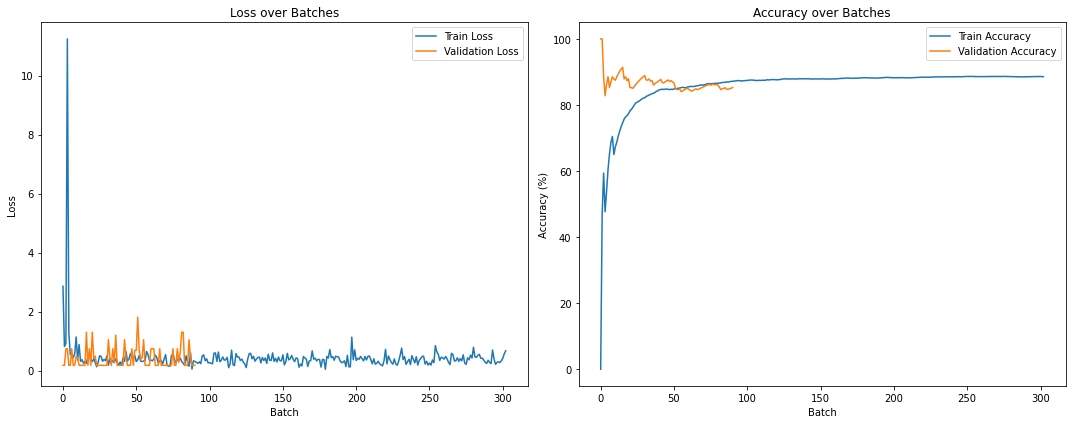


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone1     2483      100.000%
----------------------------------------
Total     2483      85.268%


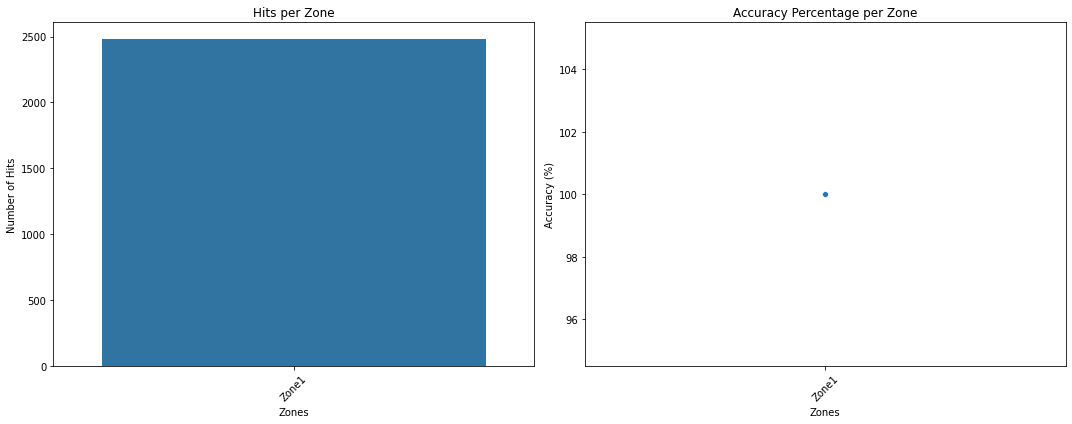

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-1.pth

Finished processing Threat Zone 1.



In [21]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [34]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,0.836796
9,tensor(0)_Zone10,0.000002
10,tensor(0)_Zone11,0.000002
11,tensor(0)_Zone12,0.000003
12,tensor(0)_Zone13,0.000002
13,tensor(0)_Zone14,0.000002
14,tensor(0)_Zone15,0.000003
15,tensor(0)_Zone16,0.000003
16,tensor(0)_Zone17,0.000003
1,tensor(0)_Zone2,0.163165


# Zone 6

In [35]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[13]  # Change this to train for a different zone

In [36]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 6: 3 train files, 1 test files
Train/Test Split for Zone 6: 3 train files, 1 test files


In [37]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 6: 7402
Batches per epoch: 232


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.9277
Batch 10, Loss: 0.3532
Batch 20, Loss: 0.5611
Batch 30, Loss: 0.2980
Batch 40, Loss: 0.1525
Batch 50, Loss: 0.2529
Batch 60, Loss: 0.1978
Batch 70, Loss: 0.5714
Batch 80, Loss: 0.2517
Batch 90, Loss: 0.5598
Batch 100, Loss: 0.3040
Batch 110, Loss: 0.4873
Batch 120, Loss: 0.3274
Batch 130, Loss: 0.4414
Batch 140, Loss: 0.1788
Batch 150, Loss: 0.2431
Batch 160, Loss: 0.3002
Batch 170, Loss: 0.3212
Batch 180, Loss: 0.4799
Batch 190, Loss: 0.1781
Batch 200, Loss: 0.3452
Batch 210, Loss: 0.3120
Batch 220, Loss: 0.6106
Batch 230, Loss: 0.2235


In [39]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.0467
Final Train Accuracy: 88.83%
Final Val Loss: 0.0164
Final Val Accuracy: 89.49%


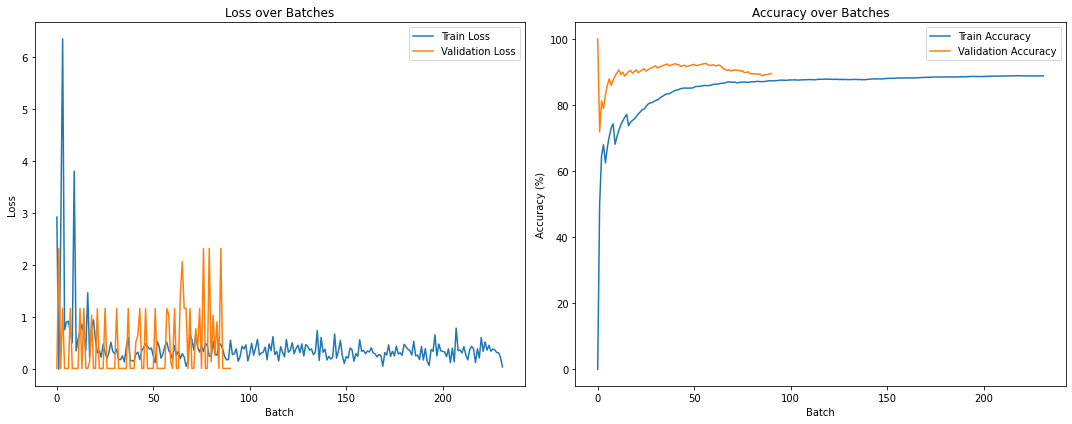


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone6     0         0.000%
----------------------------------------
Total     2606      89.492%


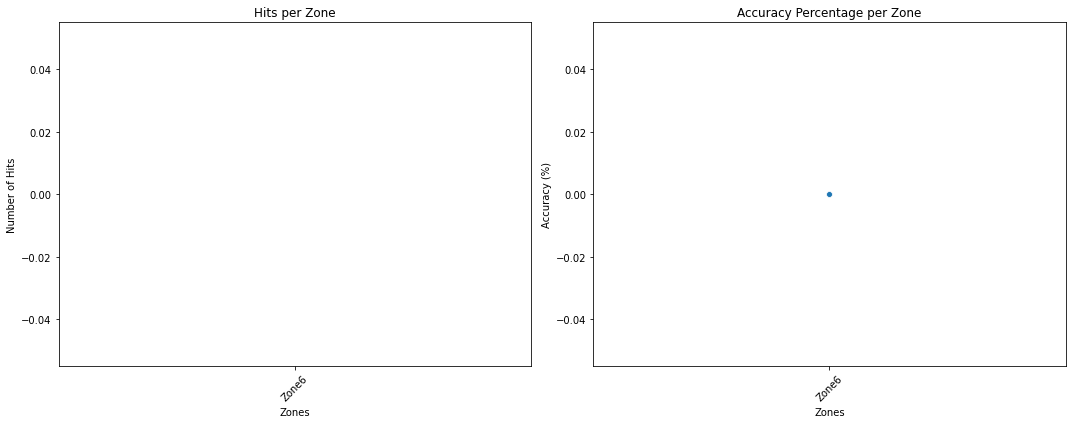

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-6.pth

Finished processing Threat Zone 6.



In [40]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [41]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.837226e-01
9,tensor(0)_Zone10,2.368358e-12
10,tensor(0)_Zone11,2.569231e-12
11,tensor(0)_Zone12,3.190259e-12
12,tensor(0)_Zone13,3.273465e-12
13,tensor(0)_Zone14,3.519782e-12
14,tensor(0)_Zone15,2.876244e-12
15,tensor(0)_Zone16,2.593721e-12
16,tensor(0)_Zone17,3.114984e-12
1,tensor(0)_Zone2,1.627733e-02


# Zone 5

In [15]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[12]  # Change this to train for a different zone

In [16]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 5: 3 train files, 1 test files
Train/Test Split for Zone 5: 3 train files, 1 test files


In [17]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 5: 6256
Batches per epoch: 196


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.9580
Batch 10, Loss: 0.6407
Batch 20, Loss: 0.2446
Batch 30, Loss: 0.4674
Batch 40, Loss: 0.3793
Batch 50, Loss: 0.1654
Batch 60, Loss: 0.5912
Batch 70, Loss: 0.3340
Batch 80, Loss: 0.8512
Batch 90, Loss: 0.4435
Batch 100, Loss: 0.1538
Batch 110, Loss: 0.0751
Batch 120, Loss: 0.4365
Batch 130, Loss: 0.3106
Batch 140, Loss: 0.3679
Batch 150, Loss: 0.4020
Batch 160, Loss: 0.4884
Batch 170, Loss: 0.3114
Batch 180, Loss: 0.3854
Batch 190, Loss: 0.3610


In [19]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.1479
Final Train Accuracy: 88.73%
Final Val Loss: 0.1432
Final Val Accuracy: 91.76%


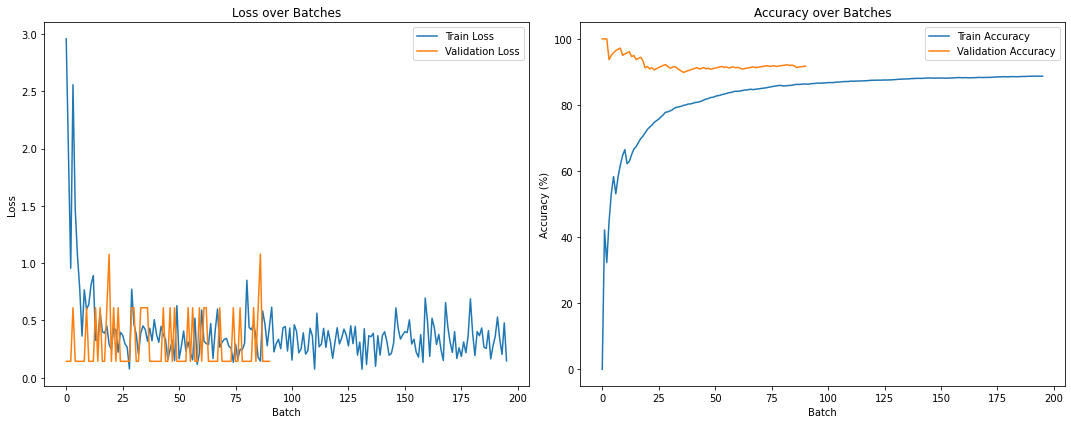


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone5     0         0.000%
----------------------------------------
Total     2672      91.758%


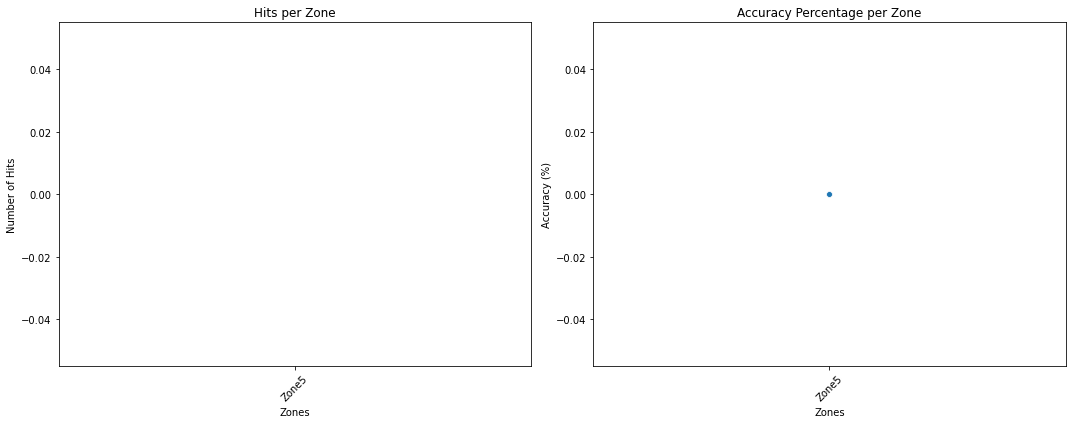

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-5.pth

Finished processing Threat Zone 5.



In [20]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [21]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,0.866621
9,tensor(0)_Zone10,0.000002
10,tensor(0)_Zone11,0.000002
11,tensor(0)_Zone12,0.000002
12,tensor(0)_Zone13,0.000002
13,tensor(0)_Zone14,0.000001
14,tensor(0)_Zone15,0.000002
15,tensor(0)_Zone16,0.000002
16,tensor(0)_Zone17,0.000001
1,tensor(0)_Zone2,0.133353


# Zone 7

In [26]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[14]  # Change this to train for a different zone

In [27]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 7: 3 train files, 1 test files
Train/Test Split for Zone 7: 3 train files, 1 test files


In [28]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 7: 6256
Batches per epoch: 196


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 0.4219
Batch 10, Loss: 0.8246
Batch 20, Loss: 0.1819
Batch 30, Loss: 0.3256
Batch 40, Loss: 0.0122
Batch 50, Loss: 0.3863
Batch 60, Loss: 0.1947
Batch 70, Loss: 0.1463
Batch 80, Loss: 0.2895
Batch 90, Loss: 0.2562
Batch 100, Loss: 0.2561
Batch 110, Loss: 0.2257
Batch 120, Loss: 0.5418
Batch 130, Loss: 0.1231
Batch 140, Loss: 0.3279
Batch 150, Loss: 0.2660
Batch 160, Loss: 0.2109
Batch 170, Loss: 0.1885
Batch 180, Loss: 0.4647
Batch 190, Loss: 0.2201


In [31]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.0623
Final Train Accuracy: 92.46%
Final Val Loss: 0.0655
Final Val Accuracy: 90.66%


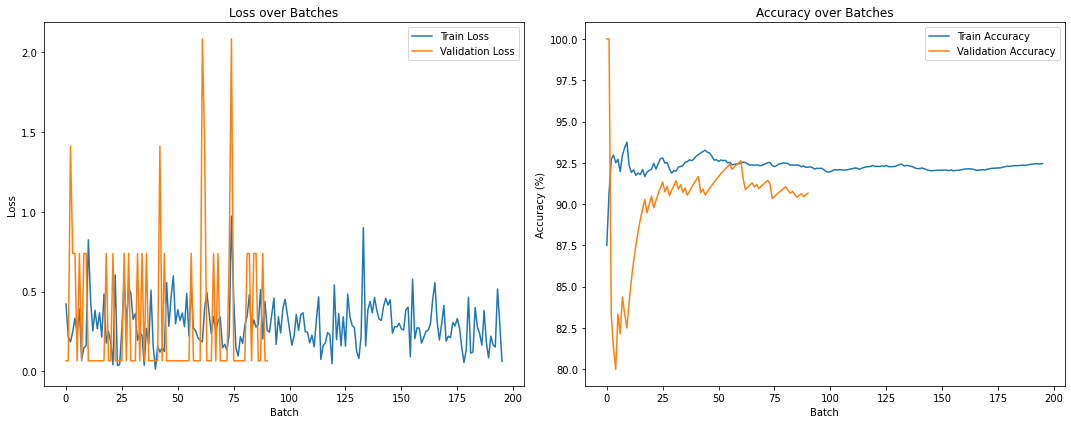


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone7     0         0.000%
----------------------------------------
Total     2640      90.659%


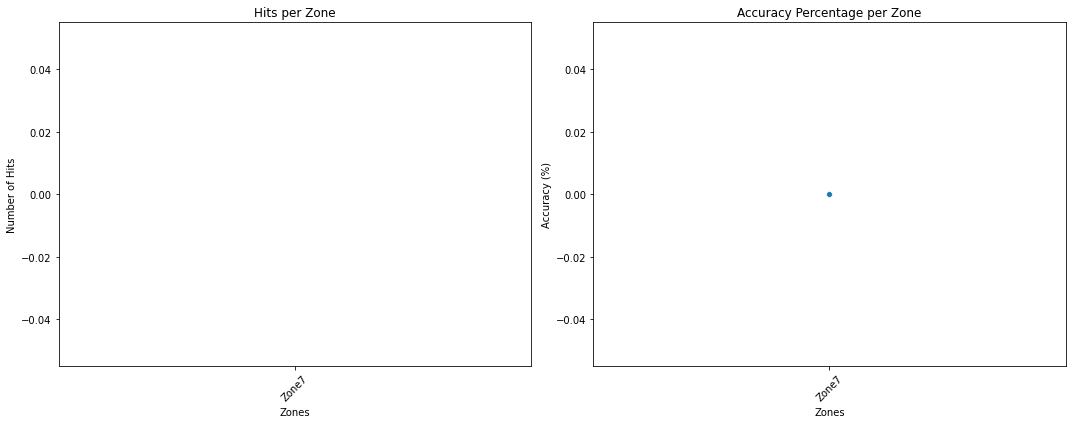

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-7.pth

Finished processing Threat Zone 7.



In [39]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [59]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.366046e-01
9,tensor(0)_Zone10,2.134043e-09
10,tensor(0)_Zone11,1.471673e-09
11,tensor(0)_Zone12,2.662971e-09
12,tensor(0)_Zone13,2.757725e-09
13,tensor(0)_Zone14,2.170268e-09
14,tensor(0)_Zone15,1.801100e-09
15,tensor(0)_Zone16,1.619202e-09
16,tensor(0)_Zone17,2.685649e-09
1,tensor(0)_Zone2,6.339545e-02


# Zone 3

In [60]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[10]  # Change this to train for a different zone

In [61]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 3: 4 train files, 1 test files
Train/Test Split for Zone 3: 4 train files, 1 test files


In [62]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 3: 10840
Batches per epoch: 339


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.8556
Batch 10, Loss: 0.1812
Batch 20, Loss: 0.4787
Batch 30, Loss: 0.2686
Batch 40, Loss: 0.5909
Batch 50, Loss: 0.6694
Batch 60, Loss: 0.5895
Batch 70, Loss: 0.3336
Batch 80, Loss: 0.2600
Batch 90, Loss: 0.3773
Batch 100, Loss: 0.7772
Batch 110, Loss: 0.6267
Batch 120, Loss: 0.2955
Batch 130, Loss: 0.4505
Batch 140, Loss: 0.4059
Batch 150, Loss: 0.1510
Batch 160, Loss: 0.3949
Batch 170, Loss: 0.2511
Batch 180, Loss: 0.3412
Batch 190, Loss: 0.2666
Batch 200, Loss: 0.2540
Batch 210, Loss: 0.3986
Batch 220, Loss: 0.3276
Batch 230, Loss: 0.2311
Batch 240, Loss: 0.2326
Batch 250, Loss: 0.6309
Batch 260, Loss: 0.3213
Batch 270, Loss: 0.2504
Batch 280, Loss: 0.1612
Batch 290, Loss: 0.4261
Batch 300, Loss: 0.3687
Batch 310, Loss: 0.2847
Batch 320, Loss: 0.2739
Batch 330, Loss: 0.4391


In [64]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.2458
Final Train Accuracy: 89.63%
Final Val Loss: 0.1016
Final Val Accuracy: 92.17%


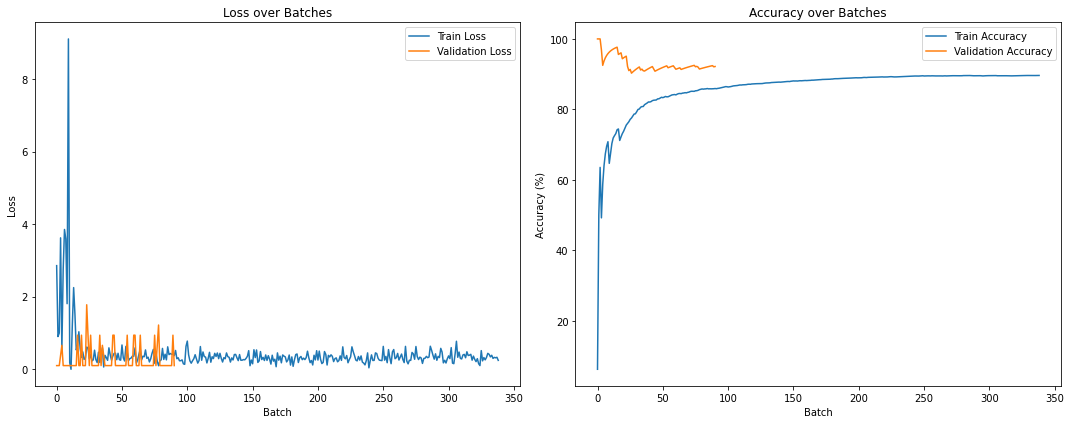


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone3     0         0.000%
----------------------------------------
Total     2684      92.170%


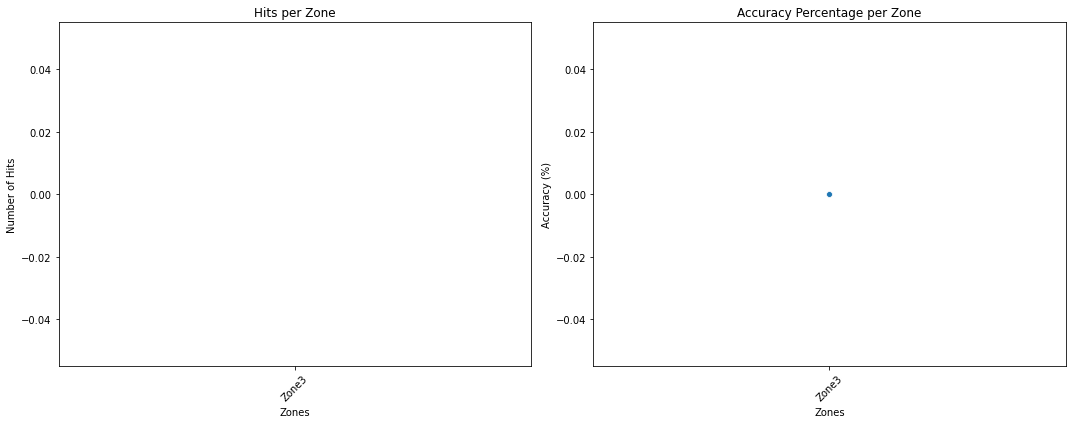

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-3.pth

Finished processing Threat Zone 3.



In [66]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [67]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.033490e-01
9,tensor(0)_Zone10,6.341377e-07
10,tensor(0)_Zone11,4.362306e-07
11,tensor(0)_Zone12,5.661590e-07
12,tensor(0)_Zone13,5.829339e-07
13,tensor(0)_Zone14,4.376599e-07
14,tensor(0)_Zone15,5.383011e-07
15,tensor(0)_Zone16,5.884619e-07
16,tensor(0)_Zone17,7.403187e-07
1,tensor(0)_Zone2,9.664281e-02


# Zone 17

In [70]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[8]  # Change this to train for a different zone

In [71]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 17: 3 train files, 1 test files
Train/Test Split for Zone 17: 3 train files, 1 test files


In [72]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 17: 6256
Batches per epoch: 196


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.8208
Batch 10, Loss: 0.3306
Batch 20, Loss: 0.4434
Batch 30, Loss: 0.1938
Batch 40, Loss: 0.2716
Batch 50, Loss: 0.2464
Batch 60, Loss: 0.1744
Batch 70, Loss: 0.2688
Batch 80, Loss: 0.3231
Batch 90, Loss: 0.2714
Batch 100, Loss: 0.3504
Batch 110, Loss: 0.0621
Batch 120, Loss: 0.2678
Batch 130, Loss: 0.2045
Batch 140, Loss: 0.1664
Batch 150, Loss: 0.2767
Batch 160, Loss: 0.2554
Batch 170, Loss: 0.1147
Batch 180, Loss: 0.3986
Batch 190, Loss: 0.4316


In [74]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.0686
Final Train Accuracy: 90.55%
Final Val Loss: 1.3282
Final Val Accuracy: 90.38%


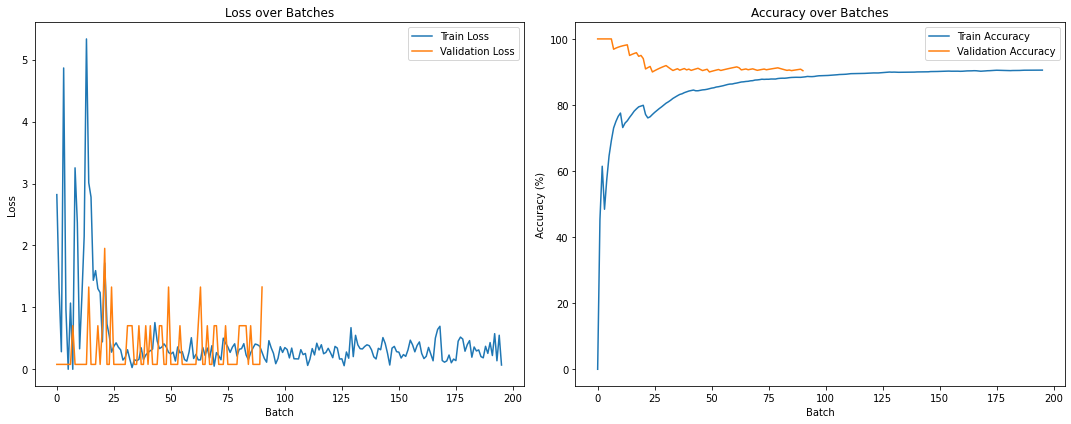


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone17    0         0.000%
----------------------------------------
Total     2632      90.385%


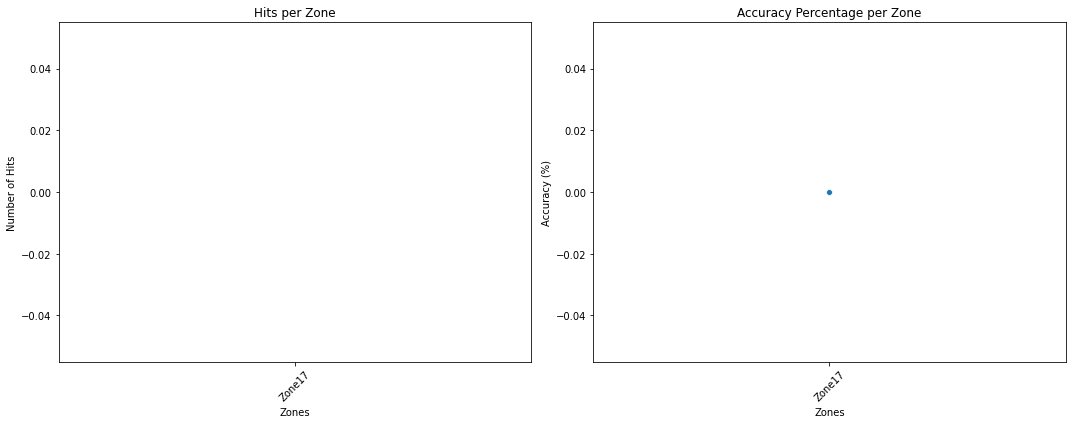

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-17.pth

Finished processing Threat Zone 17.



In [75]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [76]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.240261e-01
9,tensor(0)_Zone10,1.110258e-07
10,tensor(0)_Zone11,9.947905e-08
11,tensor(0)_Zone12,1.238223e-07
12,tensor(0)_Zone13,9.591930e-08
13,tensor(0)_Zone14,1.037624e-07
14,tensor(0)_Zone15,9.199359e-08
15,tensor(0)_Zone16,8.782093e-08
16,tensor(0)_Zone17,1.476273e-07
1,tensor(0)_Zone2,7.597229e-02


# Zone 10

In [22]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[1]  # Change this to train for a different zone

In [23]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 10: 3 train files, 1 test files
Train/Test Split for Zone 10: 3 train files, 1 test files


In [24]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 10: 6256
Batches per epoch: 196


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.9033
Batch 10, Loss: 7.8467
Batch 20, Loss: 2.1978
Batch 30, Loss: 0.3512
Batch 40, Loss: 0.3898
Batch 50, Loss: 0.4438
Batch 60, Loss: 0.2957
Batch 70, Loss: 0.1984
Batch 80, Loss: 0.2531
Batch 90, Loss: 0.1662
Batch 100, Loss: 0.1968
Batch 110, Loss: 0.3437
Batch 120, Loss: 0.4616
Batch 130, Loss: 0.2736
Batch 140, Loss: 0.2537
Batch 150, Loss: 0.2744
Batch 160, Loss: 0.4844
Batch 170, Loss: 0.2610
Batch 180, Loss: 0.3458
Batch 190, Loss: 0.2380


In [26]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.5377
Final Train Accuracy: 89.24%
Final Val Loss: 0.0560
Final Val Accuracy: 91.76%


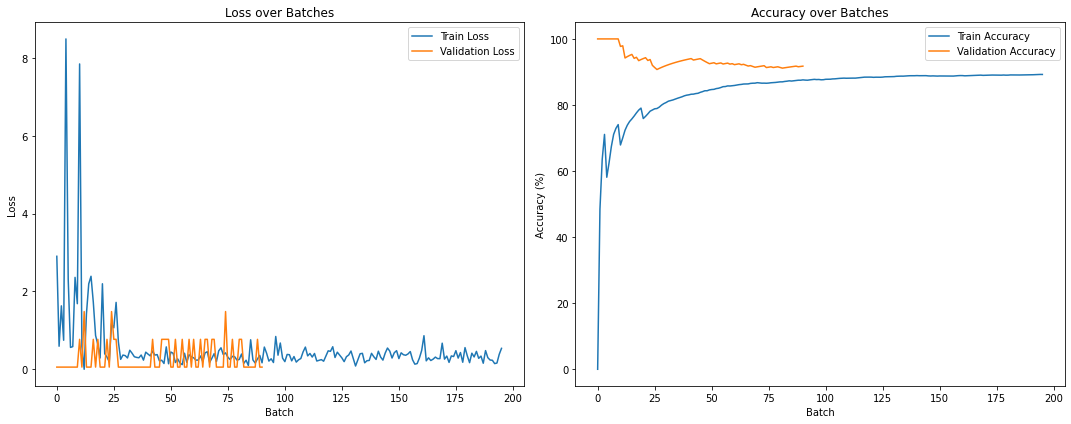


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone10    0         0.000%
----------------------------------------
Total     2672      91.758%


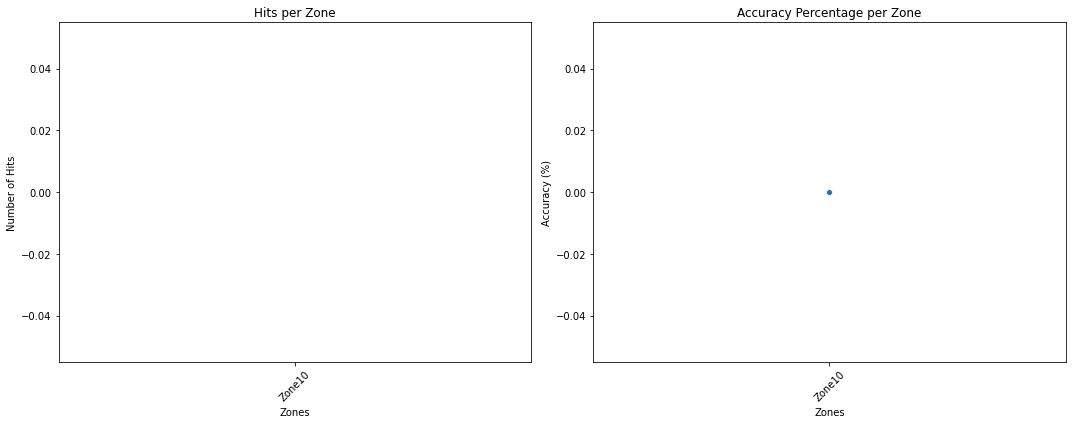

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-10.pth

Finished processing Threat Zone 10.



In [27]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [28]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.455670e-01
9,tensor(0)_Zone10,3.004100e-08
10,tensor(0)_Zone11,3.985430e-08
11,tensor(0)_Zone12,3.249830e-08
12,tensor(0)_Zone13,3.963408e-08
13,tensor(0)_Zone14,3.634115e-08
14,tensor(0)_Zone15,3.234913e-08
15,tensor(0)_Zone16,4.692966e-08
16,tensor(0)_Zone17,3.277549e-08
1,tensor(0)_Zone2,5.443254e-02


# Zone 8

In [31]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[15]  # Change this to train for a different zone

In [32]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 8: 4 train files, 1 test files
Train/Test Split for Zone 8: 4 train files, 1 test files


In [33]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 8: 9694
Batches per epoch: 303


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 3.1222
Batch 10, Loss: 1.5304
Batch 20, Loss: 0.5346
Batch 30, Loss: 0.4232
Batch 40, Loss: 0.3141
Batch 50, Loss: 0.4458
Batch 60, Loss: 0.2429
Batch 70, Loss: 0.3605
Batch 80, Loss: 0.5159
Batch 90, Loss: 0.5413
Batch 100, Loss: 0.3300
Batch 110, Loss: 0.5284
Batch 120, Loss: 0.3836
Batch 130, Loss: 0.5536
Batch 140, Loss: 0.3584
Batch 150, Loss: 0.4613
Batch 160, Loss: 0.1585
Batch 170, Loss: 0.3278
Batch 180, Loss: 0.3413
Batch 190, Loss: 0.3271
Batch 200, Loss: 0.2468
Batch 210, Loss: 0.4401
Batch 220, Loss: 0.1637
Batch 230, Loss: 0.5556
Batch 240, Loss: 0.3349
Batch 250, Loss: 0.4454
Batch 260, Loss: 0.2605
Batch 270, Loss: 0.2780
Batch 280, Loss: 0.4850
Batch 290, Loss: 0.3870
Batch 300, Loss: 0.3997


In [35]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.4332
Final Train Accuracy: 88.23%
Final Val Loss: 0.6697
Final Val Accuracy: 88.70%


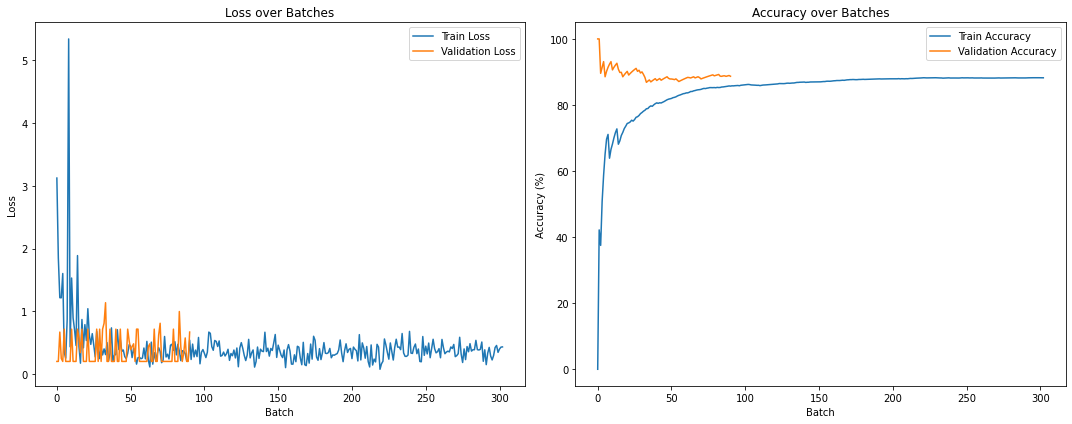


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone8     0         0.000%
----------------------------------------
Total     2583      88.702%


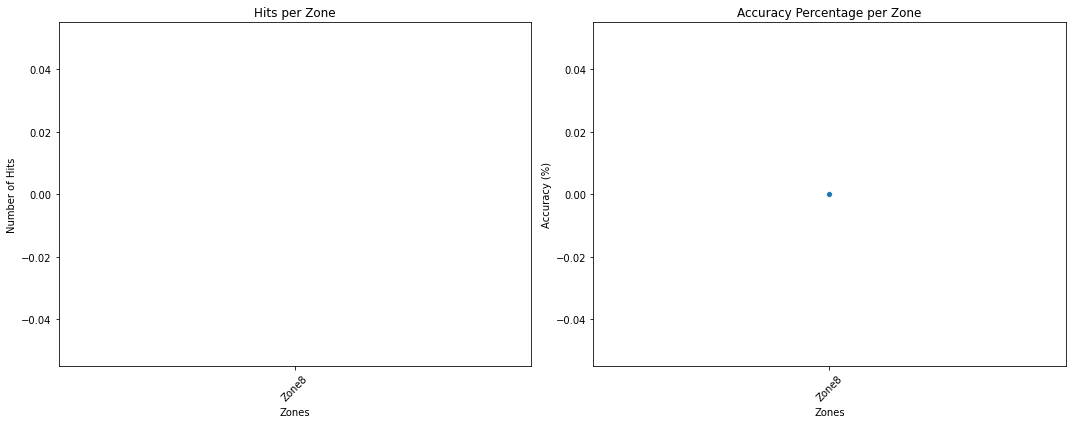

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-8.pth

Finished processing Threat Zone 8.



In [36]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [37]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,8.170328e-01
9,tensor(0)_Zone10,6.674979e-07
10,tensor(0)_Zone11,4.784408e-07
11,tensor(0)_Zone12,5.434665e-07
12,tensor(0)_Zone13,4.954249e-07
13,tensor(0)_Zone14,5.372824e-07
14,tensor(0)_Zone15,7.305403e-07
15,tensor(0)_Zone16,6.381525e-07
16,tensor(0)_Zone17,5.406651e-07
1,tensor(0)_Zone2,1.829581e-01


# Zone 9

In [16]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[16]  # Change this to train for a different zone

In [17]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 9: 3 train files, 1 test files
Train/Test Split for Zone 9: 3 train files, 1 test files


In [18]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 9: 7402
Batches per epoch: 232


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.7342
Batch 10, Loss: 17.3149
Batch 20, Loss: 0.3587
Batch 30, Loss: 0.1167
Batch 40, Loss: 0.2070
Batch 50, Loss: 0.1738
Batch 60, Loss: 0.3128
Batch 70, Loss: 0.0629
Batch 80, Loss: 0.3103
Batch 90, Loss: 0.4904
Batch 100, Loss: 0.3975
Batch 110, Loss: 0.2779
Batch 120, Loss: 0.3751
Batch 130, Loss: 0.3398
Batch 140, Loss: 0.1590
Batch 150, Loss: 0.4041
Batch 160, Loss: 0.3571
Batch 170, Loss: 0.2970
Batch 180, Loss: 0.1500
Batch 190, Loss: 0.3107
Batch 200, Loss: 0.4388
Batch 210, Loss: 0.4970
Batch 220, Loss: 0.1601
Batch 230, Loss: 0.3009


In [20]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.0419
Final Train Accuracy: 90.75%
Final Val Loss: 0.0321
Final Val Accuracy: 92.27%


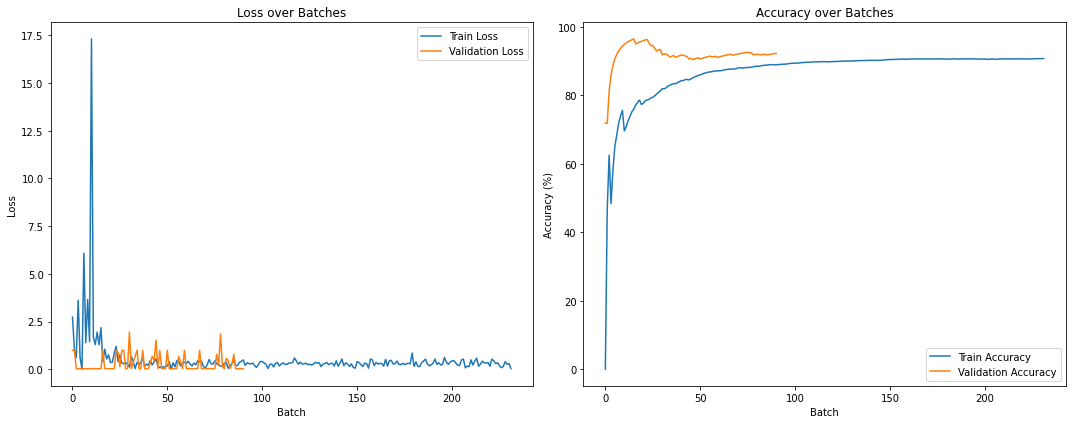


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone9     0         0.000%
----------------------------------------
Total     2687      92.273%


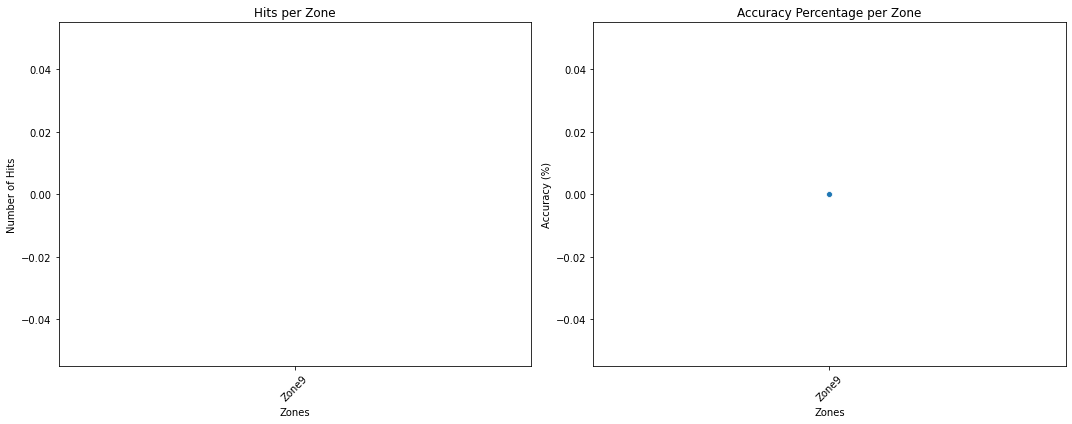

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-9.pth

Finished processing Threat Zone 9.



In [21]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [22]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.684226e-01
9,tensor(0)_Zone10,3.292799e-09
10,tensor(0)_Zone11,3.733686e-09
11,tensor(0)_Zone12,2.826495e-09
12,tensor(0)_Zone13,3.180904e-09
13,tensor(0)_Zone14,4.112809e-09
14,tensor(0)_Zone15,4.813830e-09
15,tensor(0)_Zone16,2.883810e-09
16,tensor(0)_Zone17,3.297871e-09
1,tensor(0)_Zone2,3.157738e-02


# Zone 11

In [16]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[2]  # Change this to train for a different zone

In [17]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 11: 5 train files, 1 test files
Train/Test Split for Zone 11: 5 train files, 1 test files


In [18]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 11: 11986
Batches per epoch: 375


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.6562
Batch 10, Loss: 2.4501
Batch 20, Loss: 0.4325
Batch 30, Loss: 0.2403
Batch 40, Loss: 0.4413
Batch 50, Loss: 0.3891
Batch 60, Loss: 0.3363
Batch 70, Loss: 0.6385
Batch 80, Loss: 0.3568
Batch 90, Loss: 0.3917
Batch 100, Loss: 0.4055
Batch 110, Loss: 0.2446
Batch 120, Loss: 0.2541
Batch 130, Loss: 0.3947
Batch 140, Loss: 0.5094
Batch 150, Loss: 0.1818
Batch 160, Loss: 0.3816
Batch 170, Loss: 0.1686
Batch 180, Loss: 0.1900
Batch 190, Loss: 0.2502
Batch 200, Loss: 0.6374
Batch 210, Loss: 0.2605
Batch 220, Loss: 0.2250
Batch 230, Loss: 0.3859
Batch 240, Loss: 0.1841
Batch 250, Loss: 0.7481
Batch 260, Loss: 0.5576
Batch 270, Loss: 0.2219
Batch 280, Loss: 0.3795
Batch 290, Loss: 0.3465
Batch 300, Loss: 0.3587
Batch 310, Loss: 0.2246
Batch 320, Loss: 0.2943
Batch 330, Loss: 0.5000
Batch 340, Loss: 0.2920
Batch 350, Loss: 0.3365
Batch 360, Loss: 0.4211
Batch 370, Loss: 0.2792


In [20]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.4414
Final Train Accuracy: 89.04%
Final Val Loss: 1.1983
Final Val Accuracy: 90.18%


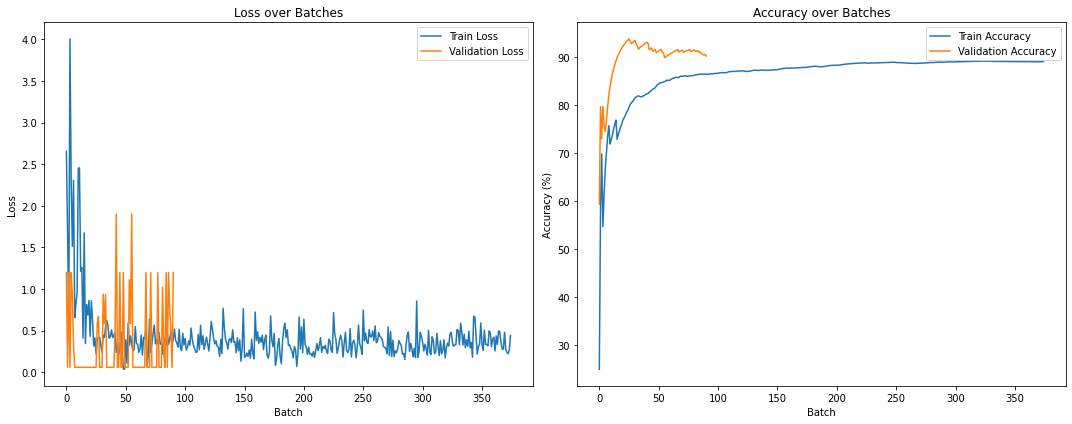


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone11    0         0.000%
----------------------------------------
Total     2626      90.179%


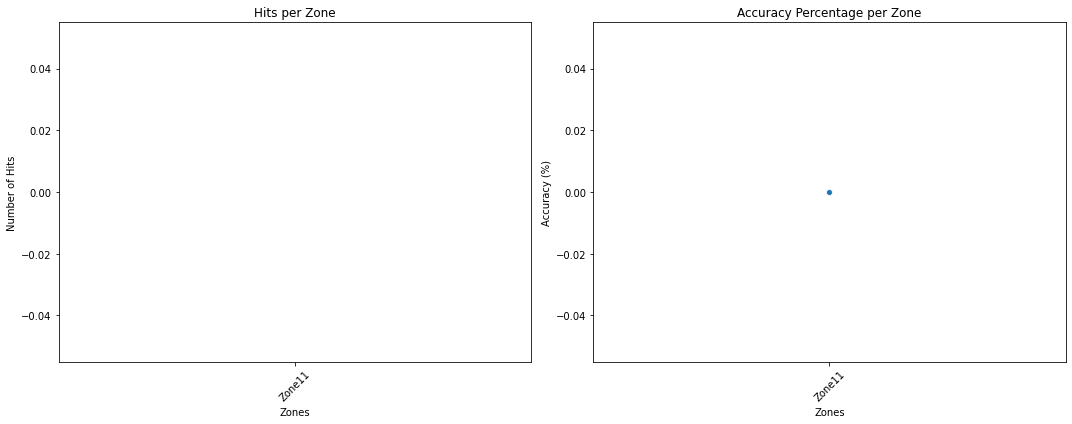

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-11.pth

Finished processing Threat Zone 11.



In [21]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [22]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
221,tensor(0)_Zone1,9.429470e-01
230,tensor(0)_Zone10,1.023948e-07
231,tensor(0)_Zone11,1.048084e-07
232,tensor(0)_Zone12,1.069700e-07
233,tensor(0)_Zone13,1.011723e-07
234,tensor(0)_Zone14,1.097740e-07
235,tensor(0)_Zone15,1.005456e-07
236,tensor(0)_Zone16,1.034721e-07
237,tensor(0)_Zone17,1.058628e-07
222,tensor(0)_Zone2,5.705142e-02


# Zone 12

In [23]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[3]  # Change this to train for a different zone

In [24]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 12: 5 train files, 1 test files
Train/Test Split for Zone 12: 5 train files, 1 test files


In [25]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 12: 13132
Batches per epoch: 411


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 3.0685
Batch 10, Loss: 2.6633
Batch 20, Loss: 0.7061
Batch 30, Loss: 0.3457
Batch 40, Loss: 0.3291
Batch 50, Loss: 0.4924
Batch 60, Loss: 0.2612
Batch 70, Loss: 0.2113
Batch 80, Loss: 0.4328
Batch 90, Loss: 0.3047
Batch 100, Loss: 0.5837
Batch 110, Loss: 0.4565
Batch 120, Loss: 0.1225
Batch 130, Loss: 0.3200
Batch 140, Loss: 0.3386
Batch 150, Loss: 0.1913
Batch 160, Loss: 0.6052
Batch 170, Loss: 0.3217
Batch 180, Loss: 0.2338
Batch 190, Loss: 0.2597
Batch 200, Loss: 0.4801
Batch 210, Loss: 0.4072
Batch 220, Loss: 0.4007
Batch 230, Loss: 0.4168
Batch 240, Loss: 0.1746
Batch 250, Loss: 0.3686
Batch 260, Loss: 0.5857
Batch 270, Loss: 0.1687
Batch 280, Loss: 0.4042
Batch 290, Loss: 0.0596
Batch 300, Loss: 0.4433
Batch 310, Loss: 0.4289
Batch 320, Loss: 0.3750
Batch 330, Loss: 0.1741
Batch 340, Loss: 0.2488
Batch 350, Loss: 0.2328
Batch 360, Loss: 0.4124
Batch 370, Loss: 0.4399
Batch 380, Loss: 0.1966
Batch 390, Loss: 0.2472
Batch 400, Loss: 0.3487
Batch 410, Loss: 0.1191


In [27]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.1191
Final Train Accuracy: 90.29%
Final Val Loss: 1.3775
Final Val Accuracy: 92.31%


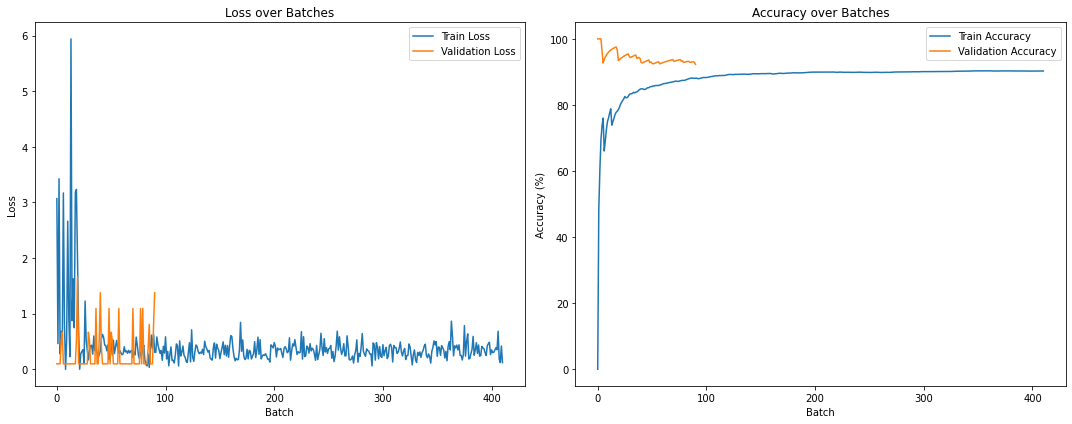


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone12    0         0.000%
----------------------------------------
Total     2688      92.308%


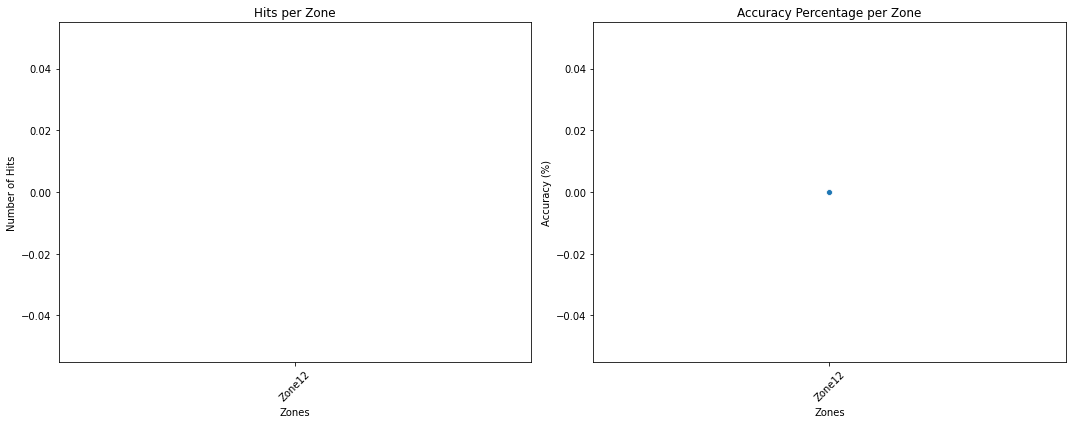

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-12.pth

Finished processing Threat Zone 12.



In [28]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [29]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.067773e-01
9,tensor(0)_Zone10,4.572052e-08
10,tensor(0)_Zone11,4.764703e-08
11,tensor(0)_Zone12,4.444158e-08
12,tensor(0)_Zone13,4.877379e-08
13,tensor(0)_Zone14,5.048951e-08
14,tensor(0)_Zone15,4.584303e-08
15,tensor(0)_Zone16,4.746273e-08
16,tensor(0)_Zone17,4.299906e-08
1,tensor(0)_Zone2,9.322199e-02


# Zone 13

In [15]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[4]  # Change this to train for a different zone

In [16]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 13: 5 train files, 1 test files
Train/Test Split for Zone 13: 5 train files, 1 test files


In [17]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 13: 11986
Batches per epoch: 375


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.6565
Batch 10, Loss: 0.5881
Batch 20, Loss: 0.4211
Batch 30, Loss: 0.3531
Batch 40, Loss: 0.4283
Batch 50, Loss: 0.4561
Batch 60, Loss: 0.2577
Batch 70, Loss: 0.3221
Batch 80, Loss: 0.2711
Batch 90, Loss: 0.5027
Batch 100, Loss: 0.3870
Batch 110, Loss: 0.3060
Batch 120, Loss: 1.0777
Batch 130, Loss: 0.2894
Batch 140, Loss: 0.2296
Batch 150, Loss: 0.4475
Batch 160, Loss: 0.3792
Batch 170, Loss: 0.2698
Batch 180, Loss: 0.1459
Batch 190, Loss: 0.2840
Batch 200, Loss: 0.1830
Batch 210, Loss: 0.1317
Batch 220, Loss: 0.5181
Batch 230, Loss: 0.2324
Batch 240, Loss: 0.4144
Batch 250, Loss: 0.4182
Batch 260, Loss: 0.2502
Batch 270, Loss: 0.1170
Batch 280, Loss: 0.5170
Batch 290, Loss: 0.3887
Batch 300, Loss: 0.4661
Batch 310, Loss: 0.2452
Batch 320, Loss: 0.3885
Batch 330, Loss: 0.1075
Batch 340, Loss: 0.0910
Batch 350, Loss: 0.3270
Batch 360, Loss: 0.4236
Batch 370, Loss: 0.3943


In [19]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.3688
Final Train Accuracy: 89.49%
Final Val Loss: 0.6149
Final Val Accuracy: 91.07%


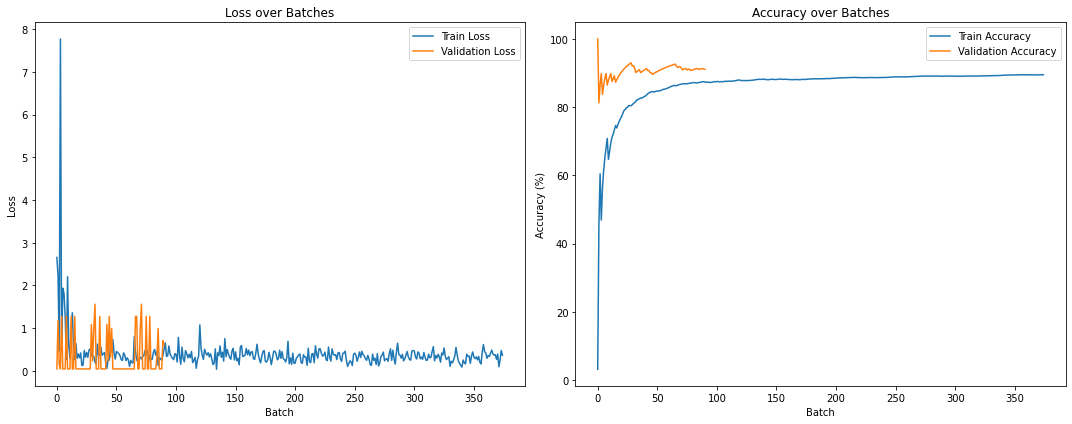


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone13    0         0.000%
----------------------------------------
Total     2652      91.071%


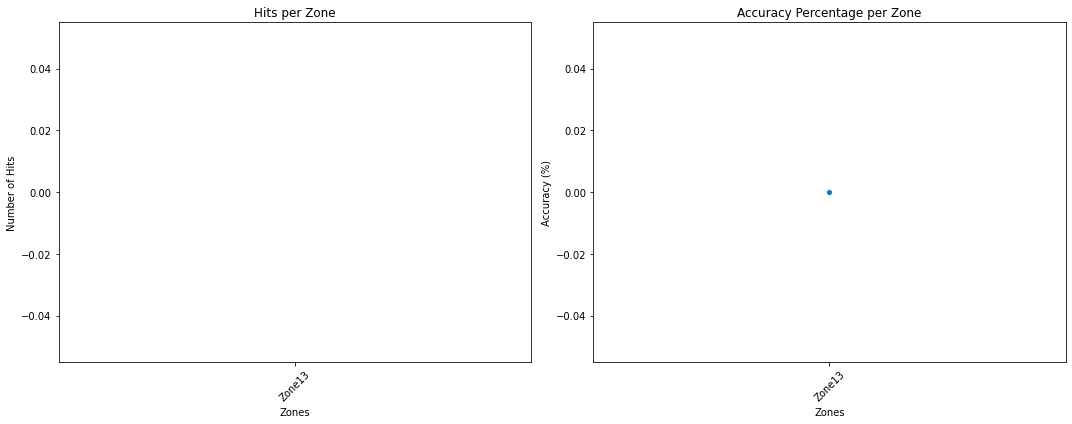

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-13.pth

Finished processing Threat Zone 13.



In [20]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [21]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.537812e-01
9,tensor(0)_Zone10,1.591572e-07
10,tensor(0)_Zone11,1.549597e-07
11,tensor(0)_Zone12,1.105282e-07
12,tensor(0)_Zone13,1.454406e-07
13,tensor(0)_Zone14,1.782923e-07
14,tensor(0)_Zone15,1.340055e-07
15,tensor(0)_Zone16,1.093201e-07
16,tensor(0)_Zone17,1.137270e-07
1,tensor(0)_Zone2,4.621682e-02


# Zone 14

In [15]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[5]  # Change this to train for a different zone

In [16]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 14: 3 train files, 1 test files
Train/Test Split for Zone 14: 3 train files, 1 test files


In [17]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 14: 8548
Batches per epoch: 268


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 3.0255
Batch 10, Loss: 0.6200
Batch 20, Loss: 0.5639
Batch 30, Loss: 0.3940
Batch 40, Loss: 0.2953
Batch 50, Loss: 0.2538
Batch 60, Loss: 0.3973
Batch 70, Loss: 0.2994
Batch 80, Loss: 0.3066
Batch 90, Loss: 0.2731
Batch 100, Loss: 0.3776
Batch 110, Loss: 0.3362
Batch 120, Loss: 0.1899
Batch 130, Loss: 0.3662
Batch 140, Loss: 0.2209
Batch 150, Loss: 0.2158
Batch 160, Loss: 0.2644
Batch 170, Loss: 0.4377
Batch 180, Loss: 0.2783
Batch 190, Loss: 0.4691
Batch 200, Loss: 0.2913
Batch 210, Loss: 0.2401
Batch 220, Loss: 0.3310
Batch 230, Loss: 0.3638
Batch 240, Loss: 0.4643
Batch 250, Loss: 0.2951
Batch 260, Loss: 0.7059


In [19]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.4572
Final Train Accuracy: 88.73%
Final Val Loss: 0.0990
Final Val Accuracy: 88.32%


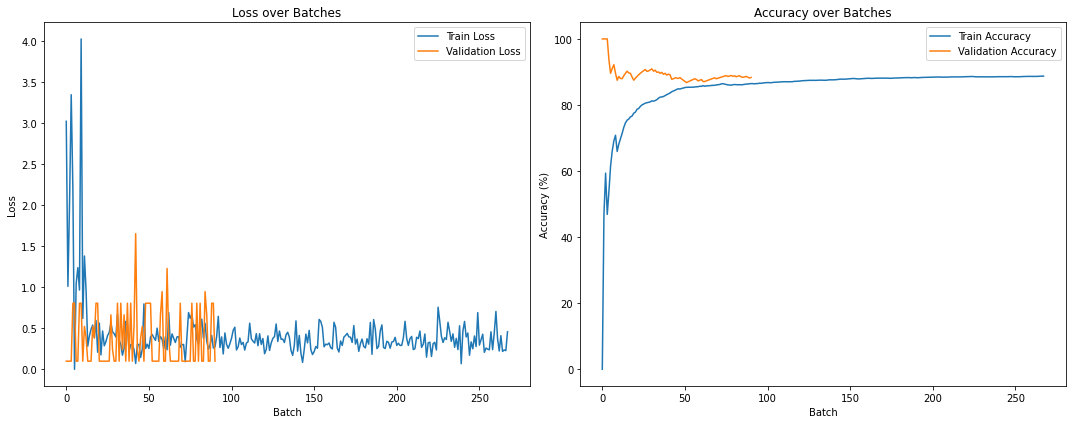


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone14    0         0.000%
----------------------------------------
Total     2572      88.324%


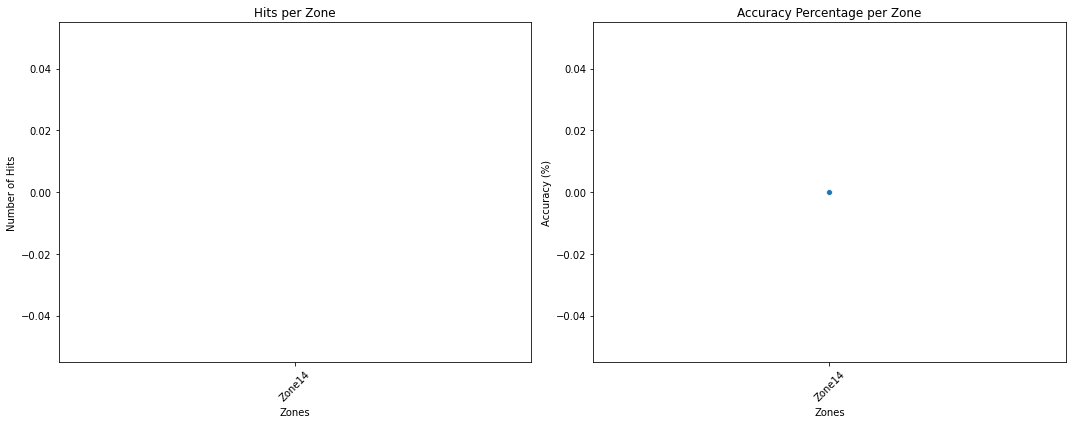

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-14.pth

Finished processing Threat Zone 14.



In [20]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [21]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,9.057756e-01
9,tensor(0)_Zone10,8.893669e-08
10,tensor(0)_Zone11,8.494156e-08
11,tensor(0)_Zone12,9.319277e-08
12,tensor(0)_Zone13,1.019884e-07
13,tensor(0)_Zone14,8.478148e-08
14,tensor(0)_Zone15,1.127226e-07
15,tensor(0)_Zone16,8.861143e-08
16,tensor(0)_Zone17,8.618018e-08
1,tensor(0)_Zone2,9.422284e-02


# Zone 15

In [23]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[6]  # Change this to train for a different zone

In [24]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 15: 4 train files, 1 test files
Train/Test Split for Zone 15: 4 train files, 1 test files


In [25]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 15: 11648
Batches per epoch: 364


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.6808
Batch 10, Loss: 0.6077
Batch 20, Loss: 0.4315
Batch 30, Loss: 0.4649
Batch 40, Loss: 0.8323
Batch 50, Loss: 0.3712
Batch 60, Loss: 0.4303
Batch 70, Loss: 0.2576
Batch 80, Loss: 0.3372
Batch 90, Loss: 0.4232
Batch 100, Loss: 0.1410
Batch 110, Loss: 0.3534
Batch 120, Loss: 0.2410
Batch 130, Loss: 0.4501
Batch 140, Loss: 0.3320
Batch 150, Loss: 0.1779
Batch 160, Loss: 0.1858
Batch 170, Loss: 0.3250
Batch 180, Loss: 0.5761
Batch 190, Loss: 0.2932
Batch 200, Loss: 0.4375
Batch 210, Loss: 0.5072
Batch 220, Loss: 0.4422
Batch 230, Loss: 0.2984
Batch 240, Loss: 0.5872
Batch 250, Loss: 0.4136
Batch 260, Loss: 0.3449
Batch 270, Loss: 0.6741
Batch 280, Loss: 0.2815
Batch 290, Loss: 0.5730
Batch 300, Loss: 0.0961
Batch 310, Loss: 0.3819
Batch 320, Loss: 0.1638
Batch 330, Loss: 0.4848
Batch 340, Loss: 0.4600
Batch 350, Loss: 0.3816
Batch 360, Loss: 0.3759


In [27]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.2077
Final Train Accuracy: 88.56%
Final Val Loss: 0.2373
Final Val Accuracy: 91.44%


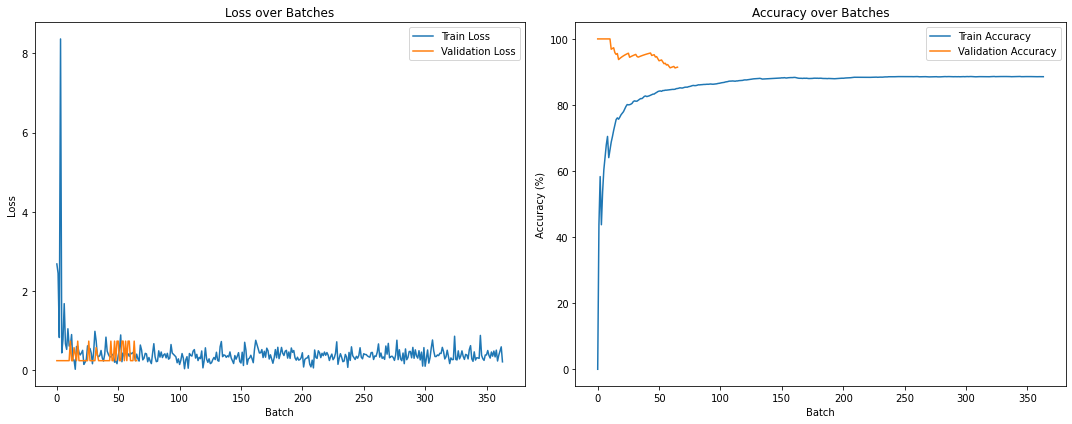


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone15    0         0.000%
----------------------------------------
Total     1924      91.445%


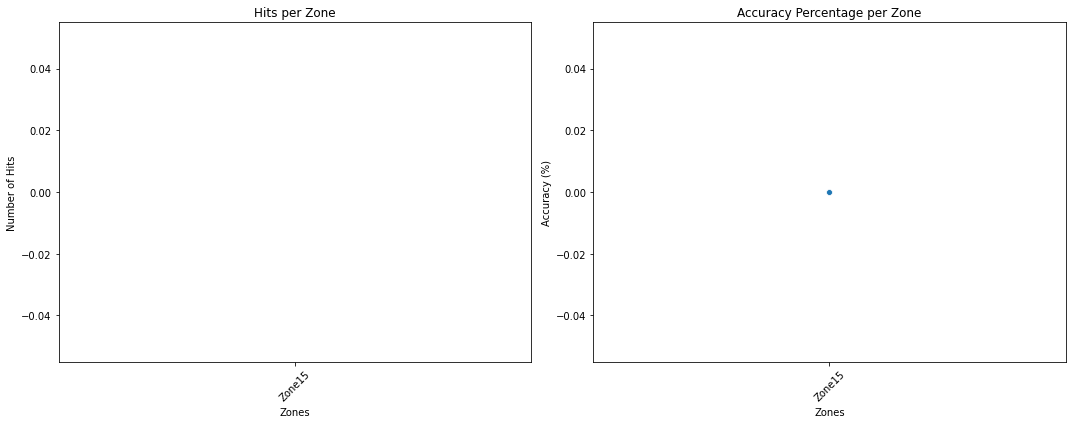

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-15.pth

Finished processing Threat Zone 15.



In [28]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [29]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,7.887518e-01
9,tensor(0)_Zone10,1.131230e-07
10,tensor(0)_Zone11,9.559522e-08
11,tensor(0)_Zone12,1.052031e-07
12,tensor(0)_Zone13,9.943126e-08
13,tensor(0)_Zone14,8.392587e-08
14,tensor(0)_Zone15,1.353055e-07
15,tensor(0)_Zone16,9.094953e-08
16,tensor(0)_Zone17,9.838876e-08
1,tensor(0)_Zone2,2.112467e-01


# Zone 16

In [32]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[7]  # Change this to train for a different zone

In [33]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 16: 5 train files, 1 test files
Train/Test Split for Zone 16: 5 train files, 1 test files


In [34]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 16: 11986
Batches per epoch: 375


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.9879
Batch 10, Loss: 0.8506
Batch 20, Loss: 0.7004
Batch 30, Loss: 0.2623
Batch 40, Loss: 0.3935
Batch 50, Loss: 0.3613
Batch 60, Loss: 0.4760
Batch 70, Loss: 0.8264
Batch 80, Loss: 0.5216
Batch 90, Loss: 0.3292
Batch 100, Loss: 0.0709
Batch 110, Loss: 0.3036
Batch 120, Loss: 0.2758
Batch 130, Loss: 0.2969
Batch 140, Loss: 0.3282
Batch 150, Loss: 0.2436
Batch 160, Loss: 0.5294
Batch 170, Loss: 0.2592
Batch 180, Loss: 0.3428
Batch 190, Loss: 0.2196
Batch 200, Loss: 0.2569
Batch 210, Loss: 0.1532
Batch 220, Loss: 0.1562
Batch 230, Loss: 0.2452
Batch 240, Loss: 0.2600
Batch 250, Loss: 0.2726
Batch 260, Loss: 0.2211
Batch 270, Loss: 0.4119
Batch 280, Loss: 0.2851
Batch 290, Loss: 0.4241
Batch 300, Loss: 0.3960
Batch 310, Loss: 0.4016
Batch 320, Loss: 0.5793
Batch 330, Loss: 0.1636
Batch 340, Loss: 0.2426
Batch 350, Loss: 0.3534
Batch 360, Loss: 0.5303
Batch 370, Loss: 0.5479


In [36]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.1909
Final Train Accuracy: 90.70%
Final Val Loss: 0.1193
Final Val Accuracy: 87.50%


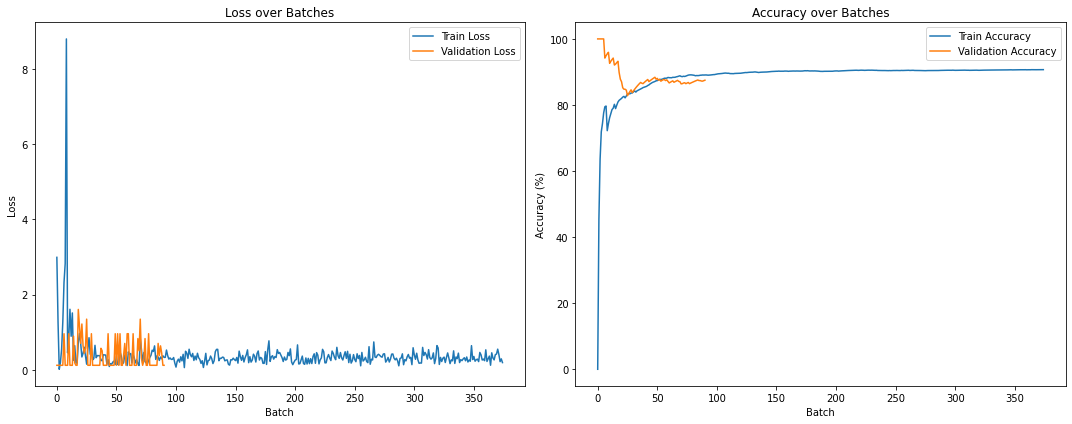


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone16    0         0.000%
----------------------------------------
Total     2548      87.500%


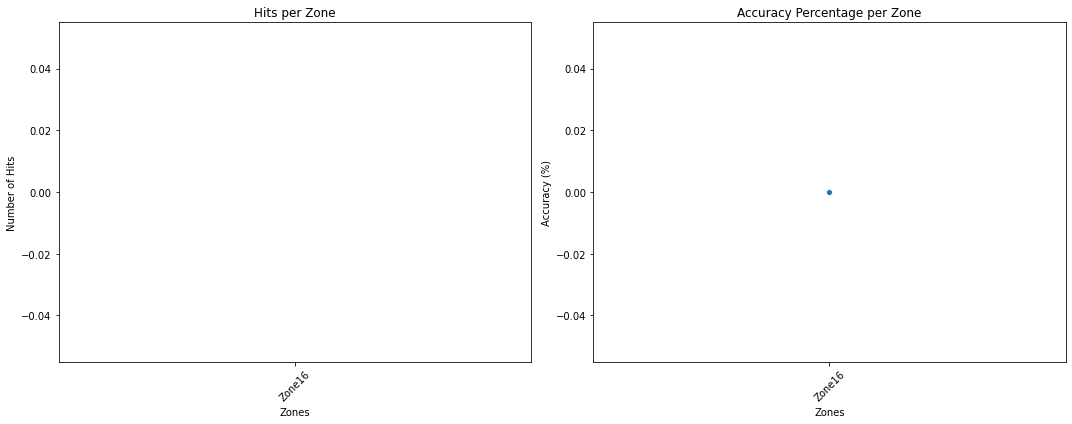

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-16.pth

Finished processing Threat Zone 16.



In [37]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [38]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,8.875263e-01
9,tensor(0)_Zone10,3.590382e-07
10,tensor(0)_Zone11,4.246766e-07
11,tensor(0)_Zone12,4.542271e-07
12,tensor(0)_Zone13,3.494297e-07
13,tensor(0)_Zone14,4.911652e-07
14,tensor(0)_Zone15,2.946950e-07
15,tensor(0)_Zone16,4.259462e-07
16,tensor(0)_Zone17,3.002776e-07
1,tensor(0)_Zone2,1.124680e-01


# Zone 2

In [17]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[9]  # Change this to train for a different zone

In [18]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 2: 4 train files, 1 test files
Train/Test Split for Zone 2: 4 train files, 1 test files


In [19]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 2: 9694
Batches per epoch: 303


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.8015
Batch 10, Loss: 1.4675
Batch 20, Loss: 0.8635
Batch 30, Loss: 0.4797
Batch 40, Loss: 0.5892
Batch 50, Loss: 0.2558
Batch 60, Loss: 0.2130
Batch 70, Loss: 0.2943
Batch 80, Loss: 0.3793
Batch 90, Loss: 0.3874
Batch 100, Loss: 0.4983
Batch 110, Loss: 0.5000
Batch 120, Loss: 0.2933
Batch 130, Loss: 0.2398
Batch 140, Loss: 0.5177
Batch 150, Loss: 0.4031
Batch 160, Loss: 0.5491
Batch 170, Loss: 0.3325
Batch 180, Loss: 0.6602
Batch 190, Loss: 0.5285
Batch 200, Loss: 0.3401
Batch 210, Loss: 0.3289
Batch 220, Loss: 0.5107
Batch 230, Loss: 0.2962
Batch 240, Loss: 0.4405
Batch 250, Loss: 0.1874
Batch 260, Loss: 0.3290
Batch 270, Loss: 0.2312
Batch 280, Loss: 0.3690
Batch 290, Loss: 0.4640
Batch 300, Loss: 0.3376


In [21]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.3346
Final Train Accuracy: 87.76%
Final Val Loss: 0.1107
Final Val Accuracy: 90.93%


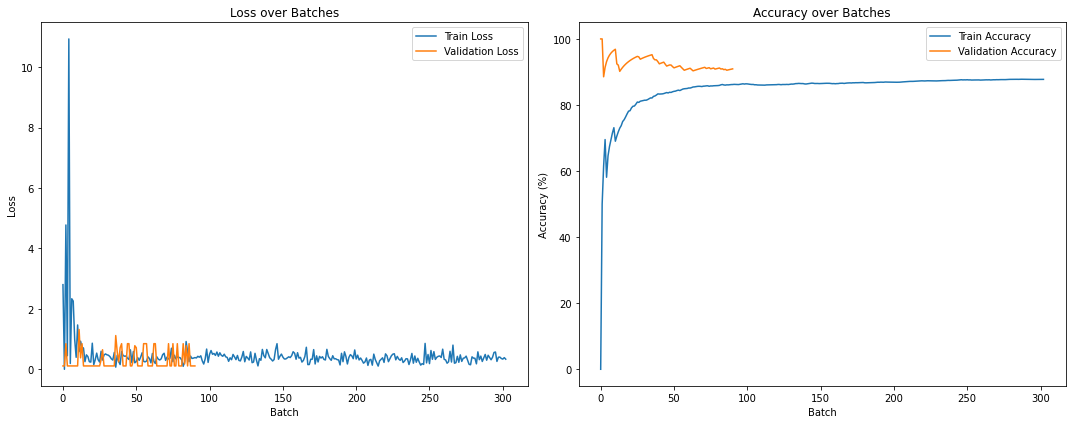


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone2     0         0.000%
----------------------------------------
Total     2648      90.934%


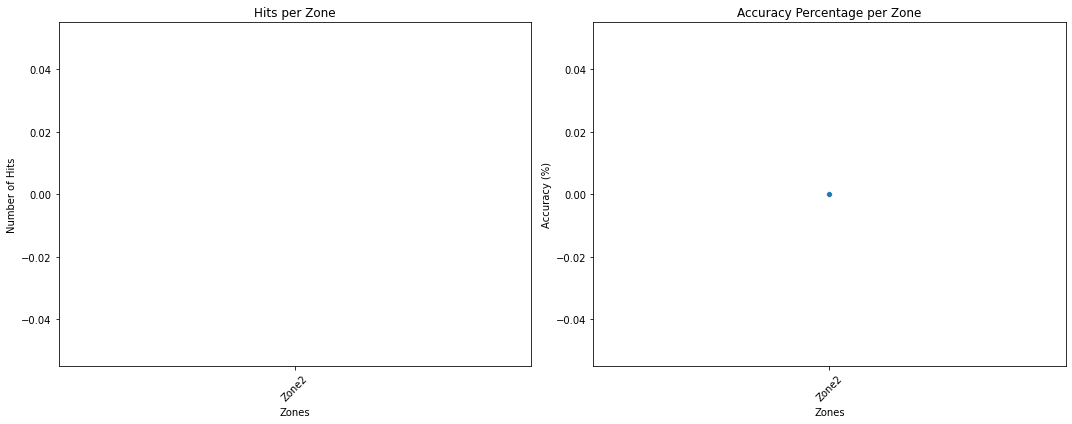

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-2.pth

Finished processing Threat Zone 2.



In [22]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [23]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,8.952236e-01
9,tensor(0)_Zone10,2.840938e-07
10,tensor(0)_Zone11,2.526247e-07
11,tensor(0)_Zone12,2.523435e-07
12,tensor(0)_Zone13,3.657130e-07
13,tensor(0)_Zone14,2.129770e-07
14,tensor(0)_Zone15,2.696768e-07
15,tensor(0)_Zone16,3.744506e-07
16,tensor(0)_Zone17,2.919045e-07
1,tensor(0)_Zone2,1.047722e-01


# Zone 4

In [24]:
df = pd.read_csv(STAGE1_LABELS)
df[['Subject', 'Zone']] = df['Id'].str.split('_', expand=True)
df['Zone'] = df['Zone'].str.replace('Zone', '').astype(int) - 1
unique_zones = df['Zone'].unique()
# Specify the threat zone to train on (0-indexed)
selected_zone = unique_zones[11]  # Change this to train for a different zone

In [25]:
# Step 1: Train-Test Split for Selected Zone
train_files, test_files = get_train_test_file_list(PREPROCESSED_DATA_FOLDER, selected_zone)

print(f"Train/Test Split for Zone {selected_zone + 1}: {len(train_files)} train files, {len(test_files)} test files")

Train/Test Split for Zone 4: 4 train files, 1 test files
Train/Test Split for Zone 4: 4 train files, 1 test files


In [26]:
# Step 2: Create DataLoaders
train_loader = load_data(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms, batch_size=BATCH_SIZE, shuffle=True)
val_loader = load_data(test_files, PREPROCESSED_DATA_FOLDER, transform=None, batch_size=BATCH_SIZE, shuffle=False)

# Initialize dataset and DataLoader
dataset = TZScanDataset(train_files, PREPROCESSED_DATA_FOLDER, transform=data_transforms)

# Calculate the total number of samples
total_samples = len(dataset)  # The __len__ method returns the total number of samples

print(f"Total training samples for Zone {selected_zone + 1}: {total_samples}")

# Calculate number of batches
batches_per_epoch = (total_samples + BATCH_SIZE - 1) // BATCH_SIZE
print(f"Batches per epoch: {batches_per_epoch}")

# Step 3: Initialize Model
num_classes = len(df['Zone'].unique())  # Assuming binary classification; adjust if different
model = initialize_model(num_classes)

# Step 4: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Total training samples for Zone 4: 10840
Batches per epoch: 339


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Step 5: Train the Model
history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, patience=30, min_delta=1e-4)

Batch 0, Loss: 2.9236
Batch 10, Loss: 6.5737
Batch 20, Loss: 0.2134
Batch 30, Loss: 0.2621
Batch 40, Loss: 0.3508
Batch 50, Loss: 0.4402
Batch 60, Loss: 0.3215
Batch 70, Loss: 0.0567
Batch 80, Loss: 0.3277
Batch 90, Loss: 0.2278
Batch 100, Loss: 0.3810
Batch 110, Loss: 0.4787
Batch 120, Loss: 0.3453
Batch 130, Loss: 0.3093
Batch 140, Loss: 0.4395
Batch 150, Loss: 0.4213
Batch 160, Loss: 0.2217
Batch 170, Loss: 0.3978
Batch 180, Loss: 0.5170
Batch 190, Loss: 0.3510
Batch 200, Loss: 0.2517
Batch 210, Loss: 0.3047
Batch 220, Loss: 0.2782
Batch 230, Loss: 0.3382
Batch 240, Loss: 0.1668
Batch 250, Loss: 0.4912
Batch 260, Loss: 0.4062
Batch 270, Loss: 0.2762
Batch 280, Loss: 0.3317
Batch 290, Loss: 0.4307
Batch 300, Loss: 0.2529
Batch 310, Loss: 0.2370
Batch 320, Loss: 0.3330
Batch 330, Loss: 0.3343


In [28]:
# After training, but before Step 6 (Plot Training History)
print("\n=== Final Training and Validation Results ===")

# Final Training Loss and Accuracy
final_train_loss = history['batch_train_loss'][-1]
final_train_accuracy = history['batch_train_accuracy'][-1]

# Final Validation Loss and Accuracy
final_val_loss = history['batch_val_loss'][-1]
final_val_accuracy = history['batch_val_accuracy'][-1]

# Print the final results
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Accuracy: {final_val_accuracy:.2f}%")


=== Final Training and Validation Results ===
Final Train Loss: 0.5875
Final Train Accuracy: 88.79%
Final Val Loss: 0.1057
Final Val Accuracy: 94.23%


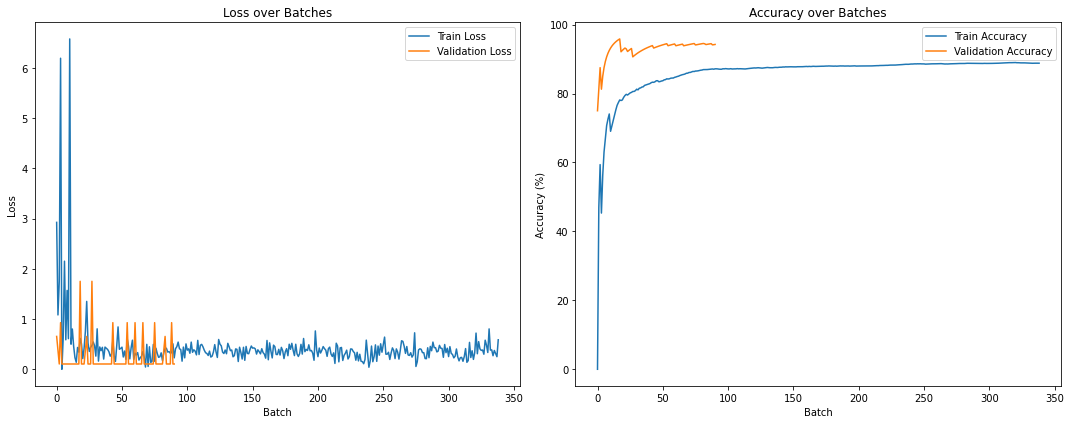


----------------------------------------
Zone      Hits      Pct %
----------------------------------------
Zone4     0         0.000%
----------------------------------------
Total     2744      94.231%


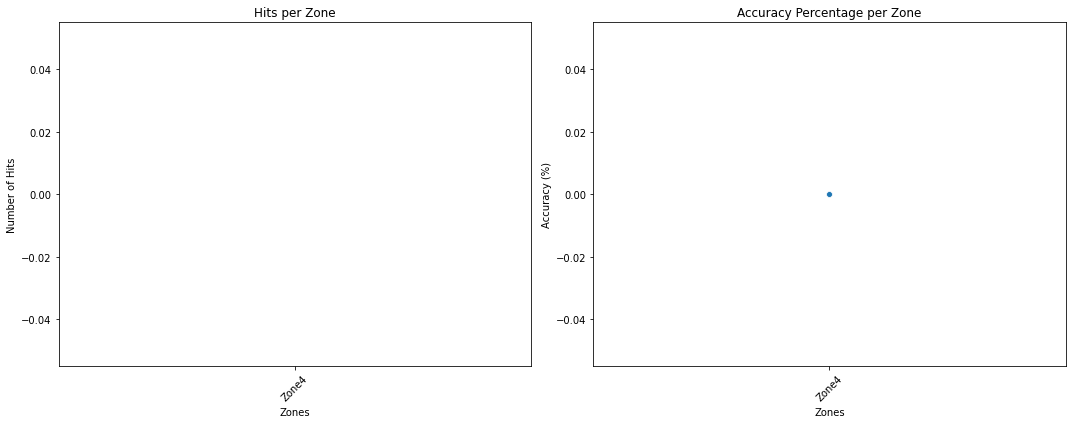

Model saved to tsa_logs/model/tsa-alexnet-lr-0.002-dim-250-tz-4.pth

Finished processing Threat Zone 4.



In [29]:
# Step 6: Plot Training History
plot_training_batches(history)

# Step 7: Analyze Zone Performance
zone_performance, total_hits, total_samples, total_pct = analyze_zone_performance(
    trained_model, val_loader, num_zones=len(df['Zone'].unique())
)

# Step 8: Display Zone Performance
display_zone_performance({f'Zone{selected_zone + 1}': zone_performance[f'Zone{selected_zone + 1}']}, total_hits, total_samples, total_pct)

# Step 9: Save Trained Model
model_filename = MODEL_NAME_TEMPLATE.format(lr=LEARNING_RATE, dim=IMAGE_DIM, tz=selected_zone + 1)
model_save_path = os.path.join(MODEL_PATH, model_filename)
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print(f"\nFinished processing Threat Zone {selected_zone + 1}.\n")

In [30]:
generate_submission(trained_model, val_loader)

Submission file saved to submission.csv


,Id,Probability
0,tensor(0)_Zone1,0.899665
9,tensor(0)_Zone10,0.000002
10,tensor(0)_Zone11,0.000002
11,tensor(0)_Zone12,0.000001
12,tensor(0)_Zone13,0.000002
13,tensor(0)_Zone14,0.000002
14,tensor(0)_Zone15,0.000002
15,tensor(0)_Zone16,0.000002
16,tensor(0)_Zone17,0.000002
1,tensor(0)_Zone2,0.100310
